In [90]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [91]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from functools import reduce
from sklearn.metrics import roc_curve

Loading and preparing data...


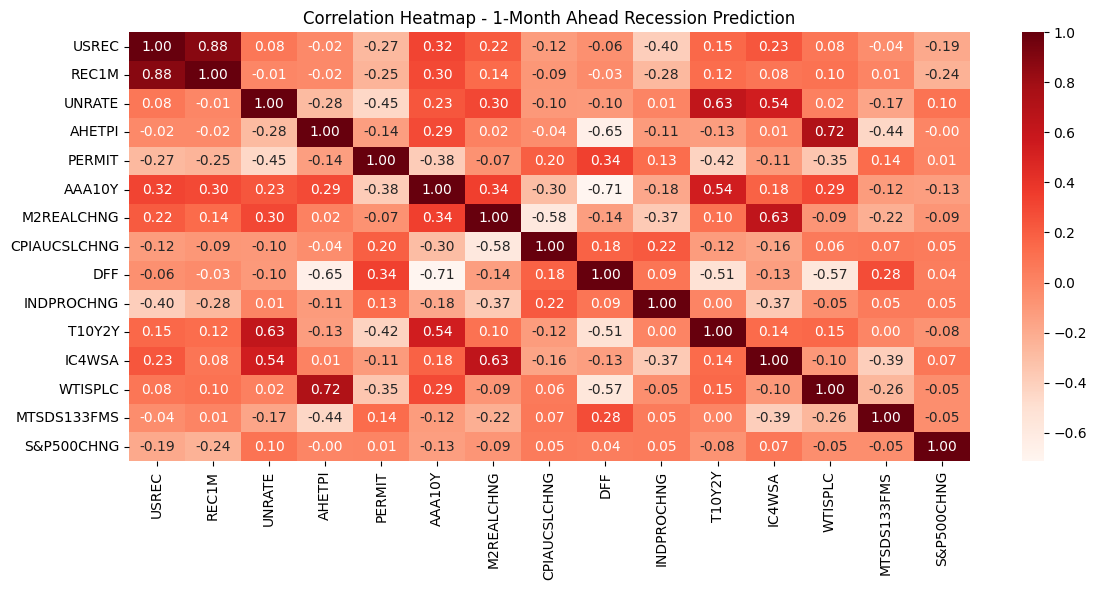

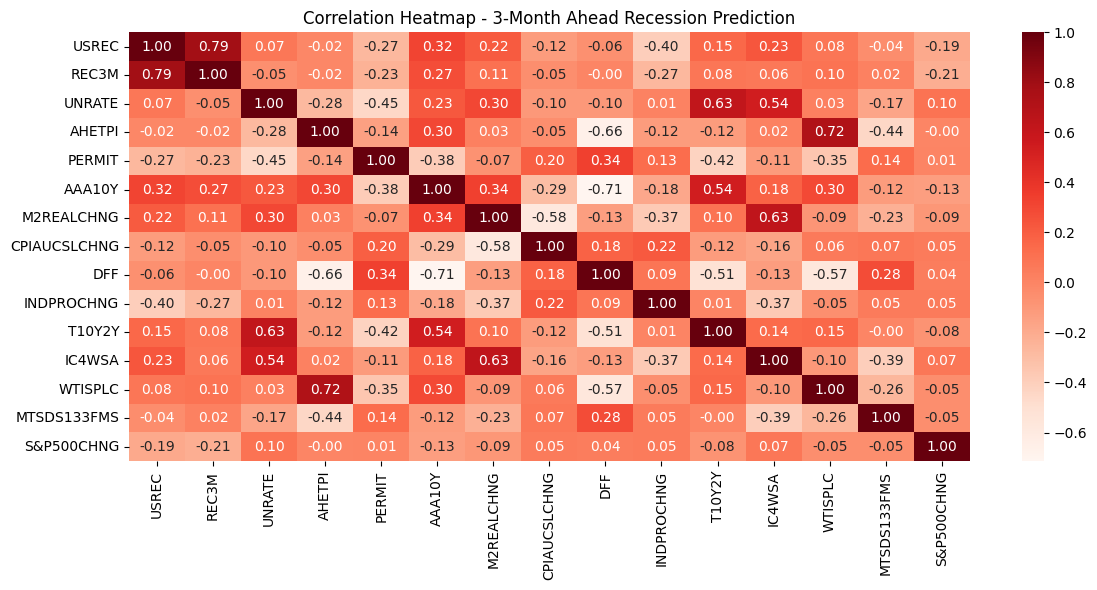

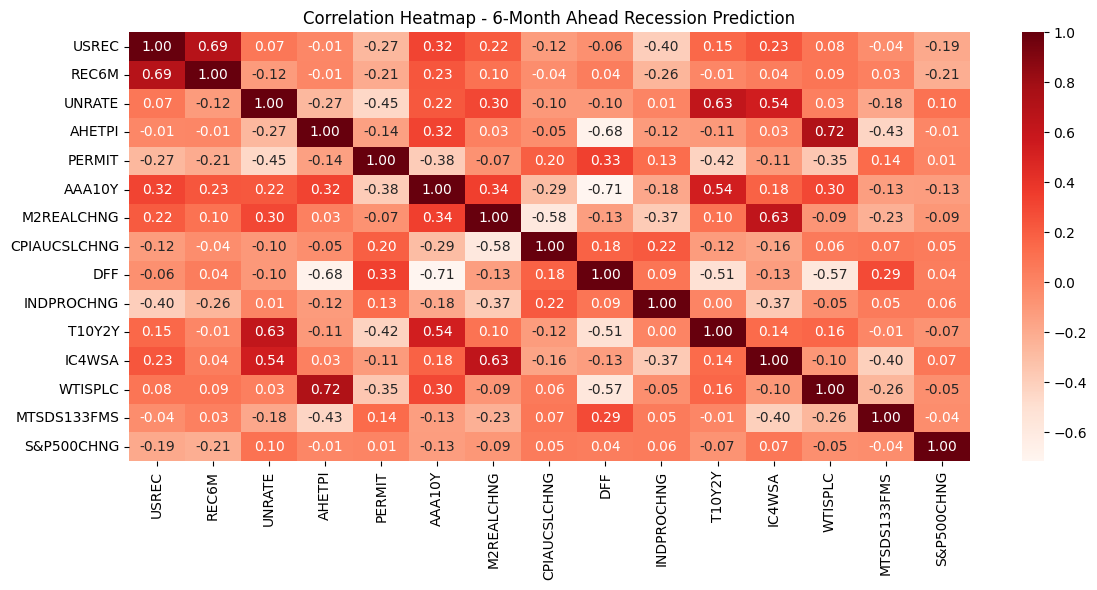

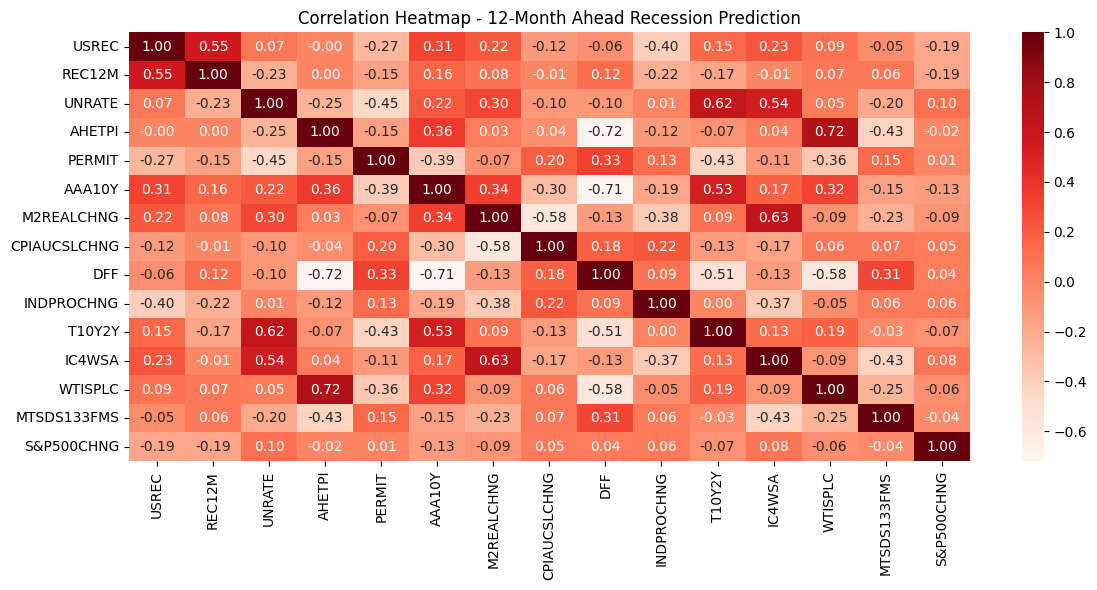

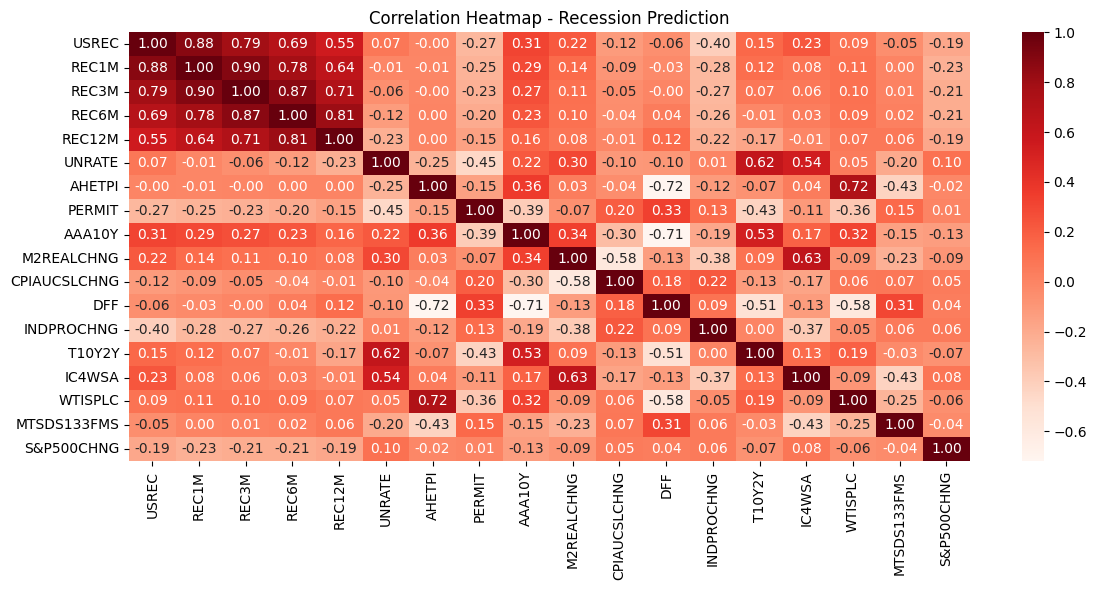

Preparing data for all horizons...
Latest data date: 2024-02-01 00:00:00


In [117]:
#DATA PREPARATION
# Load and prepare data
print("Loading and preparing data...")
data = pd.read_csv('merged_economic_data.csv', parse_dates=['observation_date'])
data_series = {
    col: data[['observation_date', col]].dropna()
    for col in data.columns if col != 'observation_date'
}

# # Calculate percentage changes for relevant columns
# change_cols = ['M2REAL', 'CPIAUCSL', 'INDPRO', 'IC4WSA', 'WTISPLC']
# for col in change_cols: 
#     data_series[f'{col}CHNG'] = pd.DataFrame({
#     'observation_date': data_series['M2REAL']['observation_date'],
#     f'{col}CHNG': data_series['M2REAL']['M2REAL'].pct_change()
#     }).dropna()

# data_series['WTISPLCACHN'] = pd.DataFrame({
#     'observation_date': data_series['WTISPLC']['observation_date'],
#     'WTISPLCACHN': data_series['WTISPLC']['WTISPLC'].pct_change()
#     }).dropna()

# Ensure 'USREC' is binary (0 or 1)
data_series['USREC']['USREC'] = data_series['USREC']['USREC'].astype(int)

# Create recession target variables for 1M, 3M, 6M, and 12M ahead
for months in [1, 3, 6, 12]:
    # If any recession occurs in the next N months, label the current row as recession
    data_series['USREC'][f'REC{months}M'] = (
        data_series['USREC']['USREC']
        .rolling(window=months, min_periods=1)
        .max()
        .shift(-months)
    )

# Merge all mini dataframes in data_series on 'observation_date'
full_data = reduce(
    lambda left, right: pd.merge(left, right, on='observation_date', how='outer'),
    data_series.values()
).sort_values('observation_date')
full_data.set_index('observation_date', inplace=True)

data = full_data.copy().dropna()

# Create separate datasets per forecast horizon
full_data_1M = full_data.drop(columns=['REC3M', 'REC6M', 'REC12M']).copy()
full_data_3M = full_data.drop(columns=['REC1M', 'REC6M', 'REC12M']).copy()
full_data_6M = full_data.drop(columns=['REC1M', 'REC3M', 'REC12M']).copy()
full_data_12M = full_data.drop(columns=['REC1M', 'REC3M', 'REC6M']).copy()

# Drop rows with any NaNs introduced by shifting
data_1M = full_data_1M.copy().dropna()
data_3M = full_data_3M.copy().dropna()
data_6M = full_data_6M.copy().dropna()
data_12M = full_data_12M.copy().dropna()

# Ensure targets are integers (0 or 1)
data_1M['USREC'] = data_1M['USREC'].astype(int)
data_3M['USREC'] = data_3M['USREC'].astype(int)
data_6M['USREC'] = data_6M['USREC'].astype(int)
data_12M['USREC'] = data_12M['USREC'].astype(int)

data_1M[f'REC1M'] = data_1M[f'REC1M'].astype(int)
data_3M[f'REC3M'] = data_3M[f'REC3M'].astype(int)
data_6M[f'REC6M'] = data_6M[f'REC6M'].astype(int)
data_12M[f'REC12M'] = data_12M[f'REC12M'].astype(int)

data['USREC'] = data['USREC'].astype(int)
data['REC1M'] = data['REC1M'].astype(int)
data['REC3M'] = data['REC3M'].astype(int)
data['REC6M'] = data['REC6M'].astype(int)
data['REC12M'] = data['REC12M'].astype(int)

data.sort_values('observation_date', inplace=True)

# Dictionary of datasets and labels
datasets = {
    "1-Month Ahead": data_1M,
    "3-Month Ahead": data_3M,
    "6-Month Ahead": data_6M,
    "12-Month Ahead": data_12M
}

# Generate correlation heatmaps for each dataset (visualization)
for label, df in datasets.items():
    plt.figure(figsize=(12, 6))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='Reds', fmt=".2f")
    plt.title(f'Correlation Heatmap - {label} Recession Prediction')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='Reds', fmt=".2f")
plt.title(f'Correlation Heatmap - Recession Prediction')
plt.tight_layout()
plt.show()

# Calculate permutation importance for feature selection
# (This could be visualized but I'll skip it to focus on models)
datasets_imp = {
    "1-Month Ahead": ("REC1M", data_1M),
    "3-Month Ahead": ("REC3M", data_3M),
    "6-Month Ahead": ("REC6M", data_6M),
    "12-Month Ahead": ("REC12M", data_12M)
}

# Set up feature sets and train-test split
feature_sets = {
    '1M': ['USREC', 'UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
    '3M': ['USREC', 'UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
    '6M': ['USREC', 'UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
    '12M': ['USREC', 'UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
}

# Set a fixed split date 
split_date = '2005-01-01'

# Store all data horizon-wise
data_by_horizon = {}

# Prepare the data for all horizons
print("Preparing data for all horizons...")
for horizon, features in feature_sets.items():
    target_column = f'REC{horizon}'

    # Reset index temporarily for correct filtering
    data.reset_index(inplace=True)
    
    # Filter for non-null values (important after feature selection)
    df = data.dropna(subset=features + [target_column])

    X = df[features]
    y = df[target_column]
    dates = df['observation_date']

    # Time-based train-test split
    X_train = X[dates < split_date]
    X_test = X[dates >= split_date]
    y_train = y[dates < split_date]
    y_test = y[dates >= split_date]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    data_by_horizon[horizon] = {
        'features': features,
        'X_train': X_train,
        'X_test': X_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }
    
    # Reset data index back
    data.set_index('observation_date', inplace=True)

# Get latest date from dataset for target date calculations
latest_data_date = data.index.max()
if not isinstance(latest_data_date, datetime):
    latest_data_date = pd.to_datetime(latest_data_date)
print(f"Latest data date: {latest_data_date}")

----------
### 1-Month Ahead Recession Prediction
Select:

- INDPROCHNG - Highest importance, strong -ve correlation with USREC.
- PERMIT - Important + negatively correlated (drop in permits = economic slowdown).
- AAA10Y - Credit spread widening is a classic recession signal.
- IC4WSA - Jobless claims show early signs of labor market stress.
- WTISPLC - Oil prices affect cost and inflation pressure.
- S&P500CHNG - Stock market often reacts early to economic shifts.

Drop or deprioritize:

- T10Y2Y - Weak importance here, but useful for longer-term.
- CPIAUCSLCHNG, M2REALCHNG - Low correlation and importance at this horizon.

--------

### 3-Month Ahead Recession Prediction
Select:

- INDPROCHNG - Still strongest signal.
- PERMIT, AAA10Y - Continued significance from housing and credit conditions.
- UNRATE - Starts becoming more relevant.
- IC4WSA, WTISPLC - Early labor + commodity signals.

Consider:

- DFF - Appears less relevant in 1M but becomes more important later.
- AHETPI - Not dominant, but still useful due to wage inflation linkage.

----------

### 6-Month Ahead Recession Prediction

Select:

- INDPROCHNG - Consistently top performer.
- AAA10Y, DFF - Both gain importance as monetary policy and credit spreads begin affecting mid-horizon.
- UNRATE, PERMIT - Strong macro indicators.
- WTISPLC - Reflects inflation/oil shock trends.

Watch:

- IC4WSA and S&P500CHNG start becoming less predictive.
- T10Y2Y is weak, but still makes some economic sense for inclusion.

--------

### 12-Month Ahead Recession Prediction

Select:

- DFF - Most important long-term indicator (Fed funds rate).
- INDPROCHNG - Reliable across all windows.
- T10Y2Y - Finally becomes useful (yield curve is famous for 12M lead).
- UNRATE, PERMIT - Structural economic indicators still hold predictive power.
- AAA10Y - Remains informative.

Drop:

- WTISPLC, S&P500CHNG, IC4WSA - Very short-term reactive, lose value here.
- M2REALCHNG - Zero importance, remove across all.

---------

### Summary Table

Horizon	Selected Features
- 1M - INDPROCHNG, PERMIT, AAA10Y, IC4WSA, WTISPLC, S&P500CHNG
- 3M - INDPROCHNG, PERMIT, AAA10Y, UNRATE, IC4WSA, WTISPLC, AHETPI, DFF
- 6M - INDPROCHNG, AAA10Y, DFF, UNRATE, PERMIT, WTISPLC, S&P500CHNG
- 12M - DFF, INDPROCHNG, T10Y2Y, UNRATE, PERMIT, AAA10Y

---------

In [118]:
#########################
# MODEL 1: LOGISTIC REGRESSION
#########################
print("\nProcessing Logistic Regression...")

# Dictionary to store results for dashboard format
lr_results = {
    "model_name": "Logistic Regression",
    "model_id": "logistic_regression",
    "color": "#FF5733",  # Hexadecimal color for the dashboard
    "predictions": {},
    "historical_data": {}
}

# Process each horizon
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing Logistic Regression for {horizon} horizon")
    
    # Get data for this horizon
    X_train = data_by_horizon[horizon]['X_train_scaled']
    X_test = data_by_horizon[horizon]['X_test_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    # Train model with increased max_iter for convergence
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = log_reg.predict(X_test)
    recession_probs = log_reg.predict_proba(X_test)[:, 1]  # Probability of recession
    
    # Ensure probabilities are valid (0-1 range)
    recession_probs = np.clip(recession_probs, 0, 1)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))
    
    # Get test dates - we need to recreate the test indices
    data.reset_index(inplace=True)
    test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
    test_dates = data.loc[test_indices, 'observation_date'].values
    data.set_index('observation_date', inplace=True)
    
    # Convert dates to strings for CSV output
    test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
    
    # Create output DataFrame with dates, actual values, and probabilities
    output_df = pd.DataFrame({
        'date': test_dates_str,
        'actual': y_test.values,
        'logistic_regression_pred': recession_probs
    })
    
    # Save to CSV
    output_file = f'logistic_regression_{horizon}_probabilities.csv'
    output_df.to_csv(output_file, index=False)
    print(f"Saved predictions to {output_file}")
    
    # Calculate target date based on latest data date
    months_ahead = int(horizon.replace('M', ''))
    target_month = latest_data_date.month + months_ahead
    target_year = latest_data_date.year
    
    # Adjust year if month exceeds 12
    while target_month > 12:
        target_month -= 12
        target_year += 1
    
    target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
    
    # Ensure the final probability is valid (between 0 and 1)
    final_prob = float(recession_probs[-1])
    final_prob = max(0, min(1, final_prob))
    
    # Store in results dictionary (for JSON later)
    lr_results["predictions"][horizon] = {
        "target_date": target_date,
        "probability": final_prob
    }
    
    lr_results["historical_data"][horizon] = output_df.to_dict(orient='records')

# Save the combined results (useful for later combining with other models)
with open('logistic_regression_complete_results.json', 'w') as f:
    json.dump(lr_results, f, indent=2)
    
print("\nAll Logistic Regression probabilities generated and saved!")


Processing Logistic Regression...

Processing Logistic Regression for 1M horizon
Accuracy: 0.961
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       210
           1       0.72      0.90      0.80        20

    accuracy                           0.96       230
   macro avg       0.86      0.93      0.89       230
weighted avg       0.97      0.96      0.96       230

Saved predictions to logistic_regression_1M_probabilities.csv

Processing Logistic Regression for 3M horizon
Accuracy: 0.935
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       206
           1       0.67      0.75      0.71        24

    accuracy                           0.93       230
   macro avg       0.82      0.85      0.83       230
weighted avg       0.94      0.93      0.94       230

Saved predictions to logistic_regression_3M_probabilities.csv

Processing Logistic Regression for 6M horizon
Accuracy: 0.88


Processing Random Forest with Cross-Validation...

Tuning Random Forest for 1M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Balanced Accuracy: 0.7973684210526316

Tuning Random Forest for 3M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Balanced Accuracy: 0.7763157894736843

Tuning Random Forest for 6M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Balanced Accuracy: 0.661578947368421

Tuning Random Forest for 12M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single l

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Mean Balanced Accuracy: 0.6803128450496871

Processing Random Forest for 1M horizon
Accuracy: 0.983
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       210
           1       1.00      0.80      0.89        20

    accuracy                           0.98       230
   macro avg       0.99      0.90      0.94       230
weighted avg       0.98      0.98      0.98       230



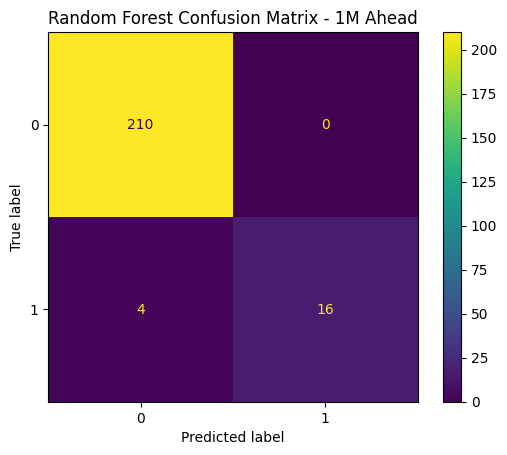

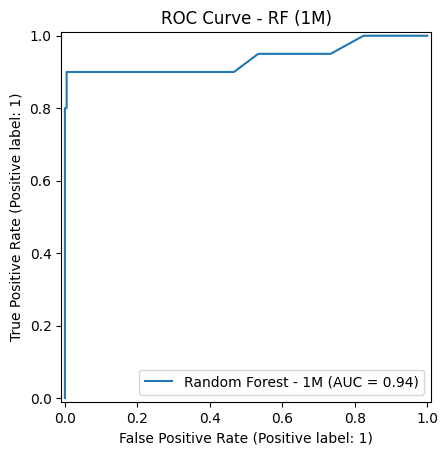

Saved complete historical predictions to random_forest_1M_complete_history.csv

Processing Random Forest for 3M horizon
Accuracy: 0.939
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       206
           1       1.00      0.42      0.59        24

    accuracy                           0.94       230
   macro avg       0.97      0.71      0.78       230
weighted avg       0.94      0.94      0.93       230



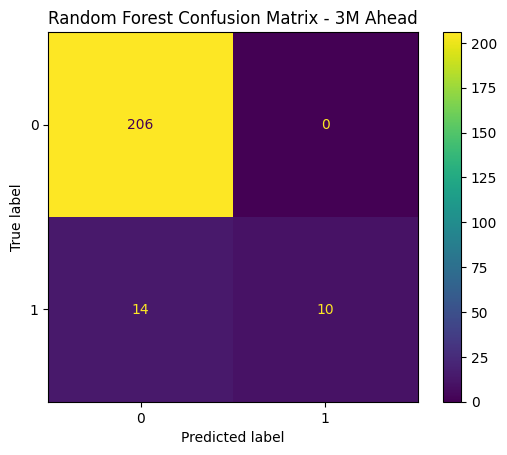

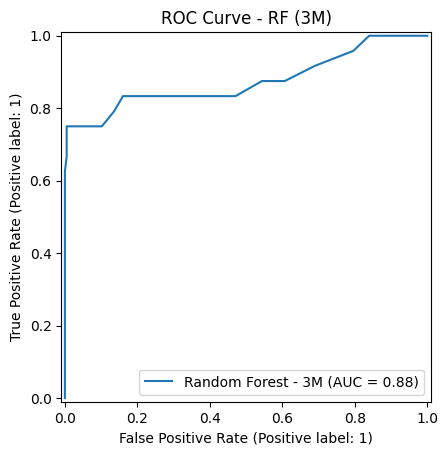

Saved complete historical predictions to random_forest_3M_complete_history.csv

Processing Random Forest for 6M horizon
Accuracy: 0.913
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       200
           1       1.00      0.33      0.50        30

    accuracy                           0.91       230
   macro avg       0.95      0.67      0.73       230
weighted avg       0.92      0.91      0.89       230



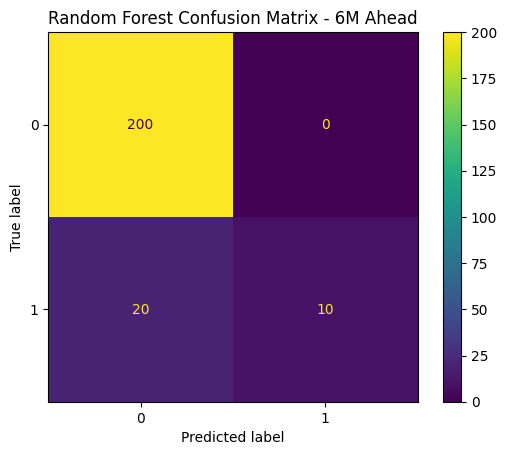

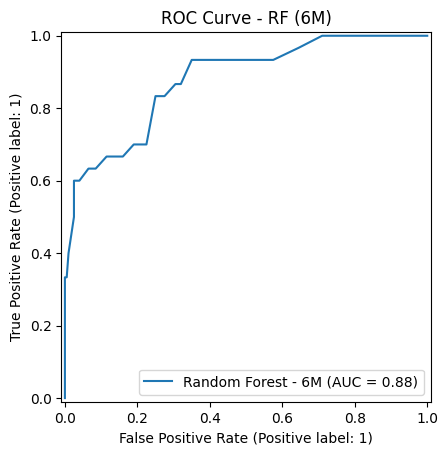

Saved complete historical predictions to random_forest_6M_complete_history.csv

Processing Random Forest for 12M horizon
Accuracy: 0.852
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       188
           1       0.83      0.24      0.37        42

    accuracy                           0.85       230
   macro avg       0.84      0.61      0.64       230
weighted avg       0.85      0.85      0.82       230



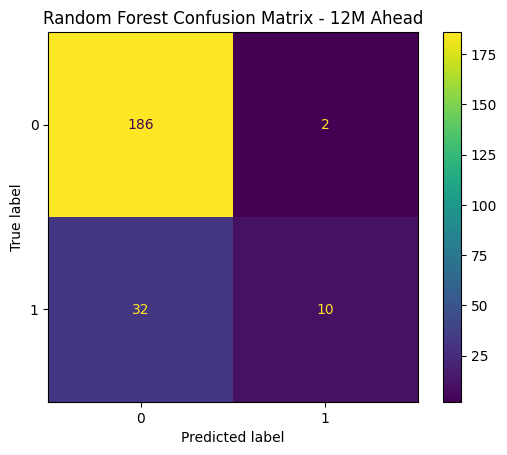

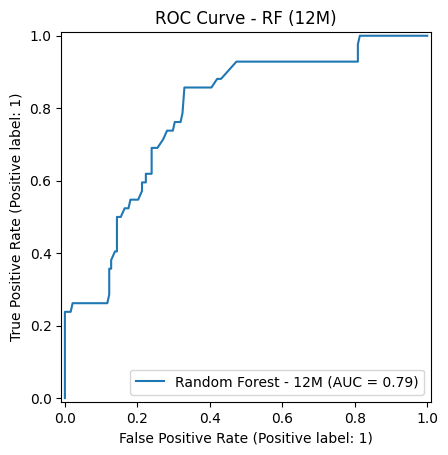

Saved complete historical predictions to random_forest_12M_complete_history.csv

Complete historical Random Forest probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [119]:
#########################
# MODEL 2: RANDOM FOREST WITH CROSS-VALIDATION
#########################
print("\nProcessing Random Forest with Cross-Validation...")

# Dictionary to store results for dashboard format
rf_results = {
    "model_name": "Random Forest",
    "model_id": "random_forest",
    "color": "#4CAF50",  # Green color for the dashboard
    "predictions": {},
    "historical_data": []
}

# First do cross-validation to find the best parameters
best_params_by_horizon = {}

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

tscv = TimeSeriesSplit(n_splits=5)

for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nTuning Random Forest for {horizon} Horizon")

    X_train = data_by_horizon[horizon]['X_train']
    y_train = data_by_horizon[horizon]['y_train']

    rf = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=tscv,
        scoring='balanced_accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Mean Balanced Accuracy:", grid_search.best_score_)

    best_params_by_horizon[horizon] = grid_search.best_params_

# Now train models with best parameters and generate predictions
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing Random Forest for {horizon} horizon")
    
    # Get data for this horizon - note we're using unscaled data 
    X_train = data_by_horizon[horizon]['X_train']
    X_test = data_by_horizon[horizon]['X_test']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    # Get best parameters from CV
    best_params = best_params_by_horizon[horizon]
    
    # Train model with best parameters
    rf = RandomForestClassifier(**best_params, random_state=42)
    rf.fit(X_train, y_train)
    
    # Make predictions for test set (post-2005)
    y_pred = rf.predict(X_test)
    test_probs = rf.predict_proba(X_test)[:, 1]
    
    # Ensure probabilities are valid (0-1 range)
    test_probs = np.clip(test_probs, 0, 1)
    
    # Evaluate model performance on test set
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix 
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    ax.set_title(f"Random Forest Confusion Matrix - {horizon} Ahead")
    plt.show()
    
    # Plot ROC Curve
    RocCurveDisplay.from_estimator(rf, X_test, y_test, name=f'Random Forest - {horizon}')
    plt.title(f'ROC Curve - RF ({horizon})')
    plt.show()
    
    # Get test dates
    data.reset_index(inplace=True)
    test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
    test_dates = data.loc[test_indices, 'observation_date'].values
    data.set_index('observation_date', inplace=True)
    
    # Convert dates to strings for CSV output
    test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
    
    # Create output DataFrame for test set
    test_output_df = pd.DataFrame({
        'date': test_dates_str,
        'actual': y_test.values,
        'random_forest_pred': test_probs
    })
    
    # Now, let's also get historical predictions for the training set (pre-2005)
    # This will give us predictions for dot-com bubble and earlier recessions
    train_probs = rf.predict_proba(X_train)[:, 1]
    
    # Ensure training probabilities are also valid
    train_probs = np.clip(train_probs, 0, 1)
    
    # Get training dates
    data.reset_index(inplace=True)
    train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
    train_dates = data.loc[train_indices, 'observation_date'].values
    data.set_index('observation_date', inplace=True)
    
    # Convert train dates to strings
    train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
    
    # Create output DataFrame for training set
    train_output_df = pd.DataFrame({
        'date': train_dates_str,
        'actual': y_train.values,
        'random_forest_pred': train_probs
    })
    
    # Combine train and test results for complete historical series
    full_output_df = pd.concat([train_output_df, test_output_df])
    
    # Filter to include only data from 1983 onwards
    full_output_df['date'] = pd.to_datetime(full_output_df['date'])
    full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
    full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
    
    # Save to CSV
    output_file = f'random_forest_{horizon}_complete_history.csv'
    full_output_df.to_csv(output_file, index=False)
    print(f"Saved complete historical predictions to {output_file}")
    
    # Calculate target date based on latest data date
    months_ahead = int(horizon.replace('M', ''))
    target_month = latest_data_date.month + months_ahead
    target_year = latest_data_date.year
    
    # Adjust year if month exceeds 12
    while target_month > 12:
        target_month -= 12
        target_year += 1
    
    target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
    
    # Ensure the final probability is valid (between 0 and 1)
    final_prob = float(test_probs[-1])
    final_prob = max(0, min(1, final_prob))
    
    # Store current prediction in results dictionary
    rf_results["predictions"][horizon] = {
        "target_date": target_date,
        "probability": final_prob
    }
    
    # Add this horizon's complete history to our collection
    if horizon == '6M':  # Let's use 6M as our default for historical data
        rf_results["historical_data"] = full_output_df.to_dict(orient='records')

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in rf_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "random_forest_pred": record["random_forest_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('random_forest_complete_results.json', 'w') as f:
    json.dump({
        "model": rf_results["model_name"],
        "model_id": rf_results["model_id"],
        "color": rf_results["color"],
        "predictions": rf_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical Random Forest probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing XGBoost with Cross-Validation...

Tuning XGBoost for 1M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 20, 'subsample': 1.0}
Best Mean Balanced Accuracy: 0.811244019138756

Tuning XGBoost for 3M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}
Best Mean Balanced Accuracy: 0.7973684210526316

Tuning XGBoost for 6M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
Best Mean Balanced Accuracy: 0.6973684210526316

Tuning XGBoost for 12M Horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in 

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
Best Mean Balanced Accuracy: 0.6631578947368422

Processing XGBoost for 1M horizon
Accuracy: 0.987
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       210
           1       0.95      0.90      0.92        20

    accuracy                           0.99       230
   macro avg       0.97      0.95      0.96       230
weighted avg       0.99      0.99      0.99       230



/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


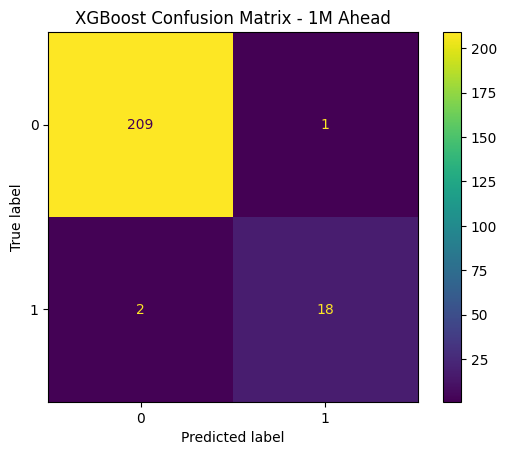

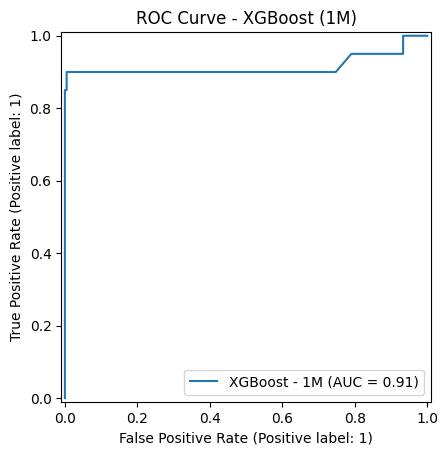

Saved complete historical predictions to xgboost_1M_complete_history.csv

Processing XGBoost for 3M horizon
Accuracy: 0.935
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       206
           1       1.00      0.38      0.55        24

    accuracy                           0.93       230
   macro avg       0.97      0.69      0.76       230
weighted avg       0.94      0.93      0.92       230



/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


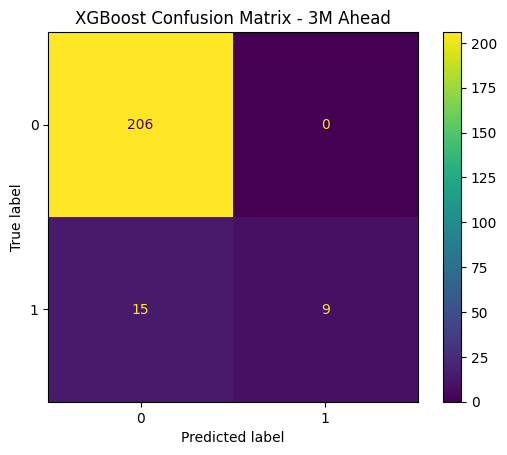

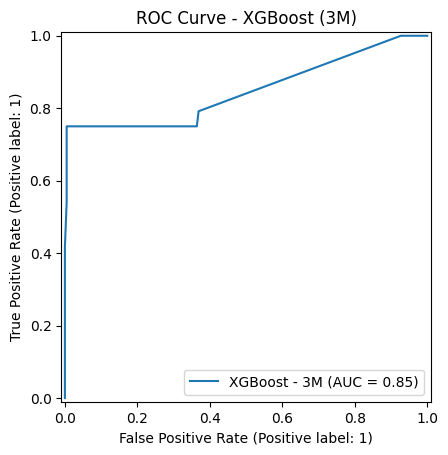

Saved complete historical predictions to xgboost_3M_complete_history.csv

Processing XGBoost for 6M horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.904
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       200
           1       1.00      0.27      0.42        30

    accuracy                           0.90       230
   macro avg       0.95      0.63      0.68       230
weighted avg       0.91      0.90      0.88       230



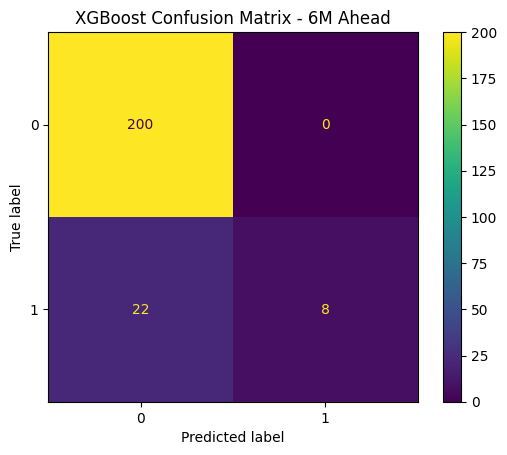

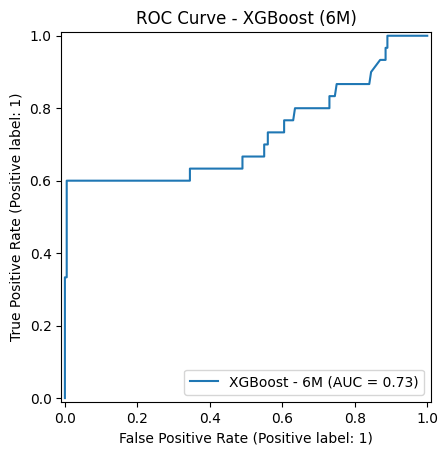

Saved complete historical predictions to xgboost_6M_complete_history.csv

Processing XGBoost for 12M horizon


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.839
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       188
           1       1.00      0.12      0.21        42

    accuracy                           0.84       230
   macro avg       0.92      0.56      0.56       230
weighted avg       0.87      0.84      0.78       230



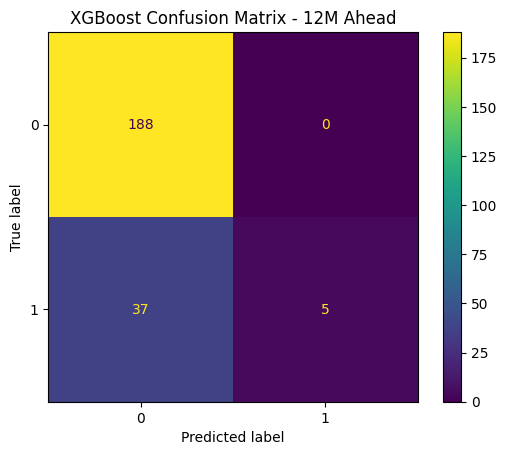

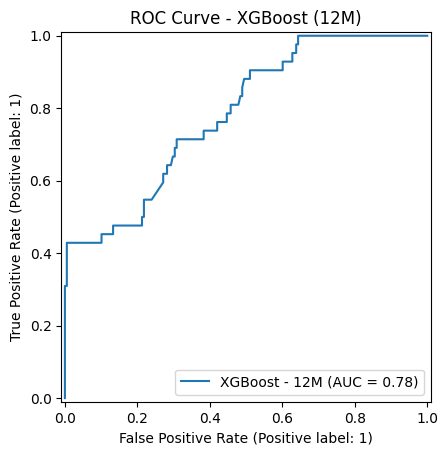

Saved complete historical predictions to xgboost_12M_complete_history.csv

Complete historical XGBoost probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [120]:
#########################
# MODEL 3: XGBOOST WITH CROSS-VALIDATION 
#########################
print("\nProcessing XGBoost with Cross-Validation...")

# Dictionary to store results for dashboard format
xgb_results = {
    "model_name": "XGBoost",
    "model_id": "xgboost",
    "color": "#3F51B5",  # Indigo color for the dashboard
    "predictions": {},
    "historical_data": []
}

# First perform cross-validation to get best parameters
best_xgb_params_by_horizon = {}

xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10, 20]
}

tscv = TimeSeriesSplit(n_splits=5)

for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nTuning XGBoost for {horizon} Horizon")

    X_train = data_by_horizon[horizon]['X_train']
    y_train = data_by_horizon[horizon]['y_train']

    xgb = XGBClassifier(eval_metric='logloss', random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=xgb_param_grid,
        cv=tscv,
        scoring='balanced_accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Mean Balanced Accuracy:", grid_search.best_score_)

    best_xgb_params_by_horizon[horizon] = grid_search.best_params_

# Now train with best parameters and generate predictions
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing XGBoost for {horizon} horizon")
    
    # Get data for this horizon - using unscaled data 
    X_train = data_by_horizon[horizon]['X_train']
    X_test = data_by_horizon[horizon]['X_test']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Get best parameters
        best_params = best_xgb_params_by_horizon[horizon]
        
        # Train model with best parameters
        xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb.fit(X_train, y_train)
        
        # Make predictions for test set (post-2005)
        y_pred = xgb.predict(X_test)
        test_probs = xgb.predict_proba(X_test)[:, 1]
        
        # Ensure probabilities are valid (0-1 range)
        test_probs = np.clip(test_probs, 0, 1)
        
        # Evaluate model performance on test set
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.3f}")
        print(classification_report(y_test, y_pred))
        
        # Plot Confusion Matrix and ROC curve as in your original code
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"XGBoost Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Plot ROC Curve
        RocCurveDisplay.from_estimator(xgb, X_test, y_test, name=f'XGBoost - {horizon}')
        plt.title(f'ROC Curve - XGBoost ({horizon})')
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'xgboost_pred': test_probs
        })
        
        # Now, get historical predictions for the training set (pre-2005)
        train_probs = xgb.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are valid
        train_probs = np.clip(train_probs, 0, 1)
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'xgboost_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'xgboost_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        xgb_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            xgb_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in XGBoost for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        xgb_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in xgb_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "xgboost_pred": record["xgboost_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('xgboost_complete_results.json', 'w') as f:
    json.dump({
        "model": xgb_results["model_name"],
        "model_id": xgb_results["model_id"],
        "color": xgb_results["color"],
        "predictions": xgb_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical XGBoost probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing Ensemble Model (Average Voting)...

Processing Ensemble Model for 1M horizon
Ensemble Accuracy: 0.983
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       210
           1       0.90      0.90      0.90        20

    accuracy                           0.98       230
   macro avg       0.95      0.95      0.95       230
weighted avg       0.98      0.98      0.98       230



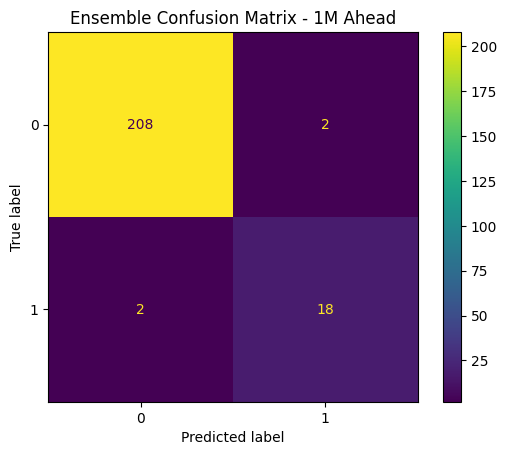

Saved complete historical predictions to ensemble_1M_complete_history.csv

Processing Ensemble Model for 3M horizon
Ensemble Accuracy: 0.965
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       206
           1       0.90      0.75      0.82        24

    accuracy                           0.97       230
   macro avg       0.94      0.87      0.90       230
weighted avg       0.96      0.97      0.96       230



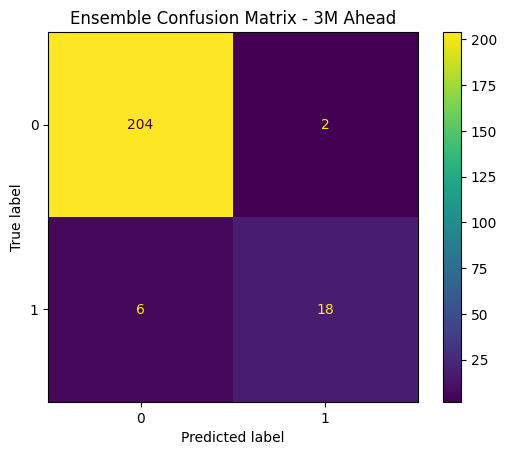

Saved complete historical predictions to ensemble_3M_complete_history.csv

Processing Ensemble Model for 6M horizon
Ensemble Accuracy: 0.939
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       200
           1       0.90      0.60      0.72        30

    accuracy                           0.94       230
   macro avg       0.92      0.79      0.84       230
weighted avg       0.94      0.94      0.93       230



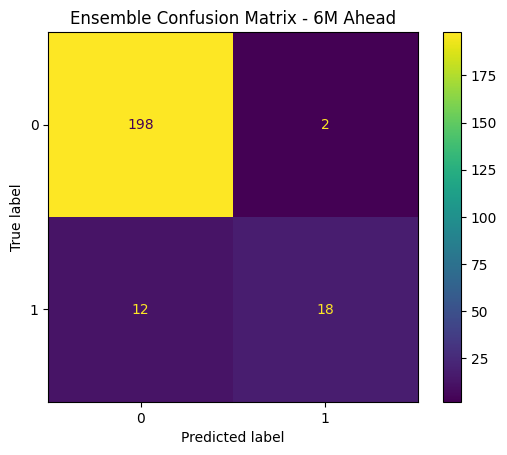

Saved complete historical predictions to ensemble_6M_complete_history.csv

Processing Ensemble Model for 12M horizon
Ensemble Accuracy: 0.874
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       188
           1       0.78      0.43      0.55        42

    accuracy                           0.87       230
   macro avg       0.83      0.70      0.74       230
weighted avg       0.87      0.87      0.86       230



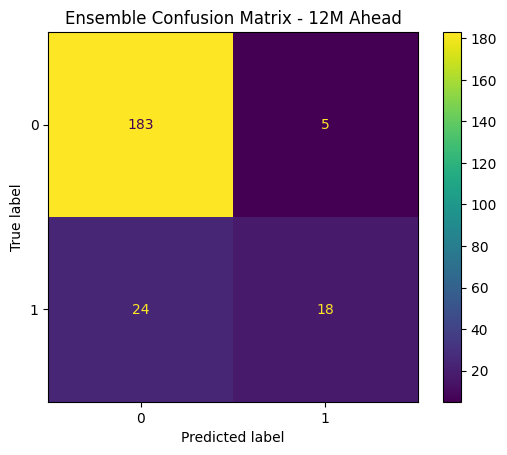

Saved complete historical predictions to ensemble_12M_complete_history.csv

Complete historical Ensemble Model probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [121]:
#########################
# MODEL 4: ENSEMBLE (AVERAGE VOTING)
#########################
print("\nProcessing Ensemble Model (Average Voting)...")

# Dictionary to store results for dashboard format
ensemble_results = {
    "model_name": "Ensemble (Avg)",
    "model_id": "ensemble_avg",
    "color": "#9C27B0",  # Purple color for the dashboard
    "predictions": {},
    "historical_data": []
}

# Process each horizon
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing Ensemble Model for {horizon} horizon")
    
    # Get data for this horizon - using both scaled and unscaled data
    X_train_scaled = data_by_horizon[horizon]['X_train_scaled']
    X_test_scaled = data_by_horizon[horizon]['X_test_scaled']
    X_train = data_by_horizon[horizon]['X_train']
    X_test = data_by_horizon[horizon]['X_test']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Train individual models with best parameters from cross-validation
        lr = LogisticRegression(max_iter=1000)
        rf = RandomForestClassifier(**best_params_by_horizon[horizon], random_state=42)
        xgb = XGBClassifier(**best_xgb_params_by_horizon[horizon], eval_metric='logloss', random_state=42)
        
        # Fit the models with their appropriate data (scaled vs unscaled)
        lr.fit(X_train_scaled, y_train)
        rf.fit(X_train, y_train)
        xgb.fit(X_train, y_train)
        
        # Make predictions for test set (post-2005)
        y_pred_lr = lr.predict_proba(X_test_scaled)[:, 1]
        y_pred_rf = rf.predict_proba(X_test)[:, 1]
        y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
        
        # Ensure individual model probabilities are valid (0-1 range)
        y_pred_lr = np.clip(y_pred_lr, 0, 1)
        y_pred_rf = np.clip(y_pred_rf, 0, 1)
        y_pred_xgb = np.clip(y_pred_xgb, 0, 1)
        
        # Average voting for ensemble probabilities (test set)
        test_probs = (y_pred_lr + y_pred_rf + y_pred_xgb) / 3
        y_pred_ensemble = (test_probs > 0.5).astype(int)
        
        # Evaluate model performance on test set
        acc = accuracy_score(y_test, y_pred_ensemble)
        print(f"Ensemble Accuracy: {acc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_ensemble))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_ensemble)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"Ensemble Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'ensemble_avg_pred': test_probs
        })
        
        # Also get predictions for training set
        y_train_lr = lr.predict_proba(X_train_scaled)[:, 1]
        y_train_rf = rf.predict_proba(X_train)[:, 1]
        y_train_xgb = xgb.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are also valid
        y_train_lr = np.clip(y_train_lr, 0, 1)
        y_train_rf = np.clip(y_train_rf, 0, 1)
        y_train_xgb = np.clip(y_train_xgb, 0, 1)
        
        # Average voting for ensemble probabilities (training set)
        train_probs = (y_train_lr + y_train_rf + y_train_xgb) / 3
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'ensemble_avg_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'ensemble_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        ensemble_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            ensemble_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in Ensemble model for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        ensemble_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in ensemble_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "ensemble_avg_pred": record["ensemble_avg_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('ensemble_complete_results.json', 'w') as f:
    json.dump({
        "model": ensemble_results["model_name"],
        "model_id": ensemble_results["model_id"],
        "color": ensemble_results["color"],
        "predictions": ensemble_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical Ensemble Model probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing Support Vector Machine with Cross-Validation...

Tuning SVM for 1M Horizon
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Mean Balanced Accuracy: nan

Tuning SVM for 3M Horizon
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Mean Balanced Accuracy: nan

Tuning SVM for 6M Horizon
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Mean Balanced Accuracy: nan

Tuning SVM for 12M Horizon
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Mean Balanced Accuracy: nan

Processing SVM for 1M horizon
SVM Accuracy: 0.917
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       210
           1       0.52      0.80      0.63        20

    accuracy                           0.92       230
   macro avg       0.75      0.86      0.79       230
weighted avg       0.94      0.92      0.93       230



/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/

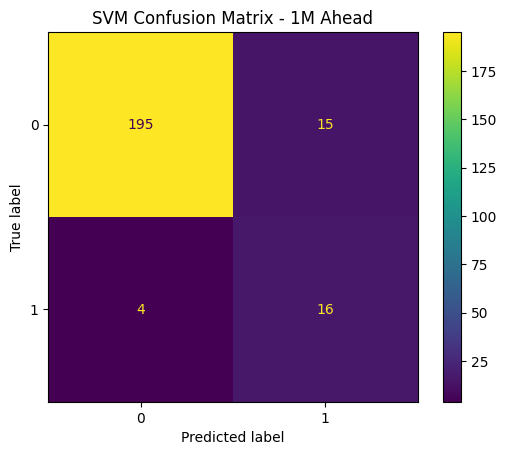

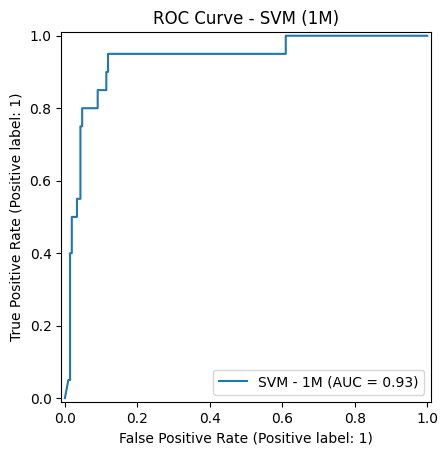

Saved complete historical predictions to svm_1M_complete_history.csv

Processing SVM for 3M horizon
SVM Accuracy: 0.917
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       206
           1       0.58      0.79      0.67        24

    accuracy                           0.92       230
   macro avg       0.78      0.86      0.81       230
weighted avg       0.93      0.92      0.92       230



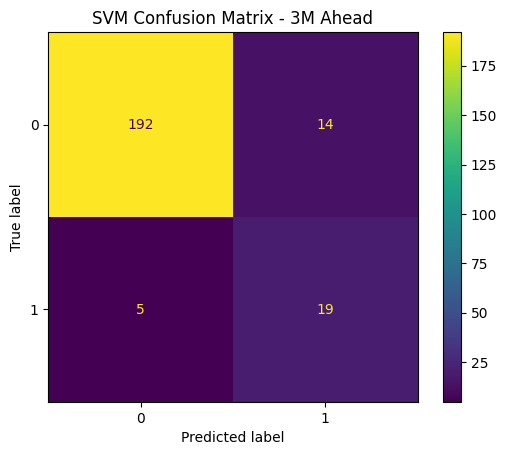

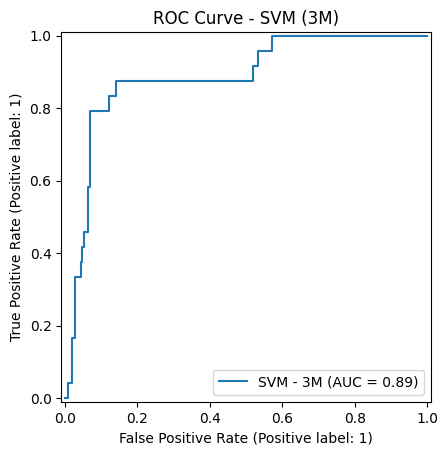

Saved complete historical predictions to svm_3M_complete_history.csv

Processing SVM for 6M horizon
SVM Accuracy: 0.687
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       200
           1       0.27      0.80      0.40        30

    accuracy                           0.69       230
   macro avg       0.61      0.74      0.59       230
weighted avg       0.87      0.69      0.74       230



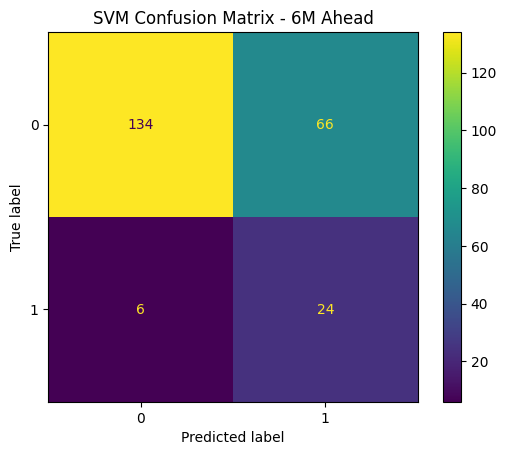

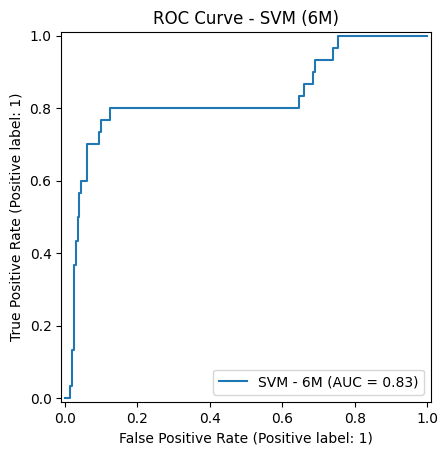

Saved complete historical predictions to svm_6M_complete_history.csv

Processing SVM for 12M horizon
SVM Accuracy: 0.861
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       188
           1       0.61      0.67      0.64        42

    accuracy                           0.86       230
   macro avg       0.77      0.79      0.78       230
weighted avg       0.87      0.86      0.86       230



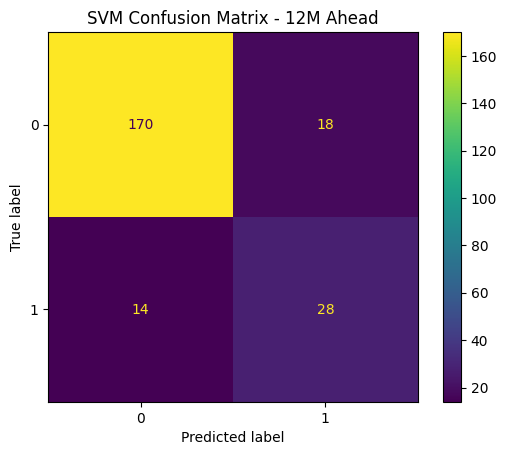

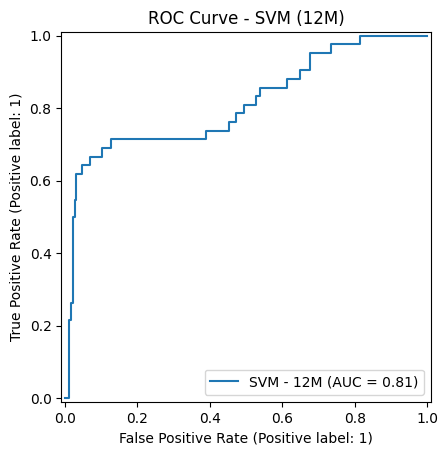

Saved complete historical predictions to svm_12M_complete_history.csv

Complete historical SVM probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [122]:
#########################
# MODEL 5: SUPPORT VECTOR MACHINE WITH CROSS-VALIDATION
#########################
print("\nProcessing Support Vector Machine with Cross-Validation...")

# Dictionary to store results for dashboard format
svm_results = {
    "model_name": "Support Vector Machine",
    "model_id": "svm",
    "color": "#E91E63",  # Pink color for the dashboard
    "predictions": {},
    "historical_data": []
}

# First do cross-validation to find best parameters
best_svm_params_by_horizon = {}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

tscv = TimeSeriesSplit(n_splits=5)

for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nTuning SVM for {horizon} Horizon")
    
    X_train = data_by_horizon[horizon]['X_train_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    
    try:
        # Time series CV for SVM
        svc = SVC(class_weight='balanced', probability=True)
        
        grid_search = GridSearchCV(
            estimator=svc,
            param_grid=svm_param_grid,
            cv=tscv,
            scoring='balanced_accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        
        print("Best Parameters:", grid_search.best_params_)
        print("Best Mean Balanced Accuracy:", grid_search.best_score_)
        
        best_svm_params_by_horizon[horizon] = grid_search.best_params_
    except Exception as e:
        print(f"Error in SVM CV for {horizon}: {e}")
        # Use default parameters if CV fails
        best_svm_params_by_horizon[horizon] = {'C': 1, 'kernel': 'rbf'}

# Now train with best parameters and generate predictions
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing SVM for {horizon} horizon")
    
    # Get data for this horizon - using scaled data
    X_train = data_by_horizon[horizon]['X_train_scaled']
    X_test = data_by_horizon[horizon]['X_test_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Train model with best parameters
        best_params = best_svm_params_by_horizon[horizon]
        svc = SVC(**best_params, class_weight='balanced', probability=True)
        svc.fit(X_train, y_train)
        
        # Make predictions
        y_pred = svc.predict(X_test)
        test_probs = svc.predict_proba(X_test)[:, 1]
        
        # Ensure probabilities are valid (0-1 range)
        test_probs = np.clip(test_probs, 0, 1)
        
        # Evaluate model performance
        acc = accuracy_score(y_test, y_pred)
        print(f"SVM Accuracy: {acc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"SVM Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Plot ROC Curve
        RocCurveDisplay.from_estimator(svc, X_test, y_test, name=f'SVM - {horizon}')
        plt.title(f'ROC Curve - SVM ({horizon})')
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'svm_pred': test_probs
        })
        
        # Get historical predictions for the training set
        train_probs = svc.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are valid
        train_probs = np.clip(train_probs, 0, 1)
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'svm_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'svm_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        svm_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            svm_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in SVM model for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        svm_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in svm_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "svm_pred": record["svm_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('svm_complete_results.json', 'w') as f:
    json.dump({
        "model": svm_results["model_name"],
        "model_id": svm_results["model_id"],
        "color": svm_results["color"],
        "predictions": svm_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical SVM probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing Gaussian Naive Bayes with Improved Priors...
Best Priors for 1M: [0.9393939393939394, 0.06060606060606061]
Best Priors for 3M: [0.9242424242424242, 0.07575757575757576]
Best Priors for 6M: [0.9015151515151515, 0.09848484848484848]
Best Priors for 12M: [0.8560606060606061, 0.14393939393939395]

Processing Gaussian Naive Bayes for 1M horizon
GNB Accuracy: 0.943
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       210
           1       0.82      0.45      0.58        20

    accuracy                           0.94       230
   macro avg       0.88      0.72      0.78       230
weighted avg       0.94      0.94      0.94       230



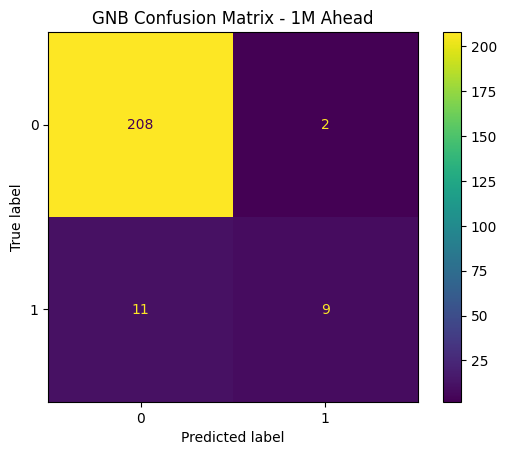

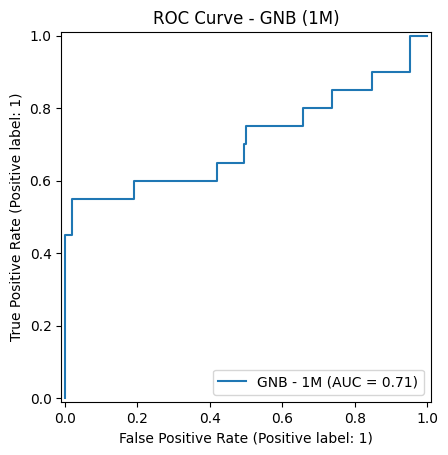

Saved complete historical predictions to naive_bayes_1M_complete_history.csv

Processing Gaussian Naive Bayes for 3M horizon
GNB Accuracy: 0.930
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       206
           1       0.79      0.46      0.58        24

    accuracy                           0.93       230
   macro avg       0.86      0.72      0.77       230
weighted avg       0.92      0.93      0.92       230



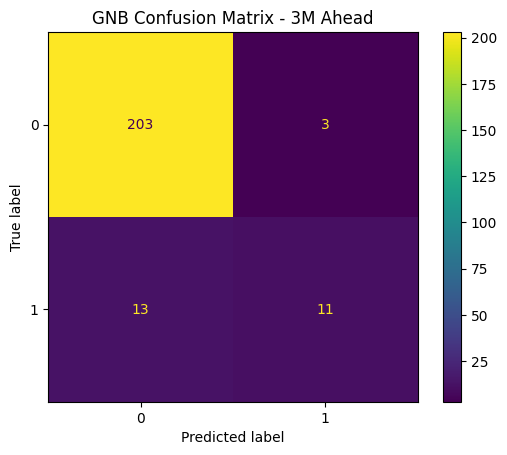

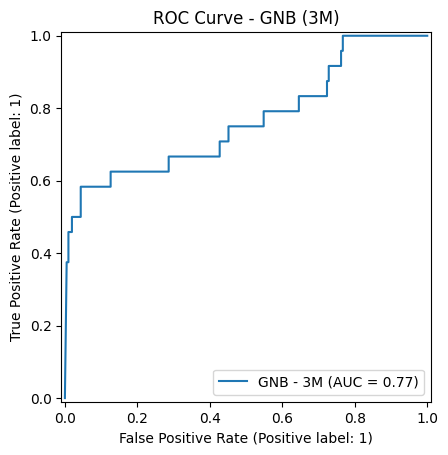

Saved complete historical predictions to naive_bayes_3M_complete_history.csv

Processing Gaussian Naive Bayes for 6M horizon
GNB Accuracy: 0.896
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       200
           1       0.64      0.47      0.54        30

    accuracy                           0.90       230
   macro avg       0.78      0.71      0.74       230
weighted avg       0.89      0.90      0.89       230



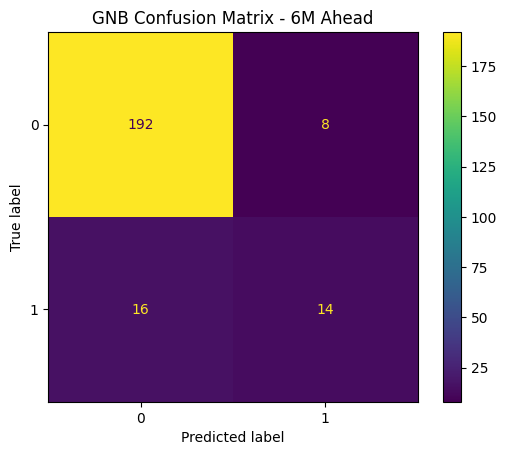

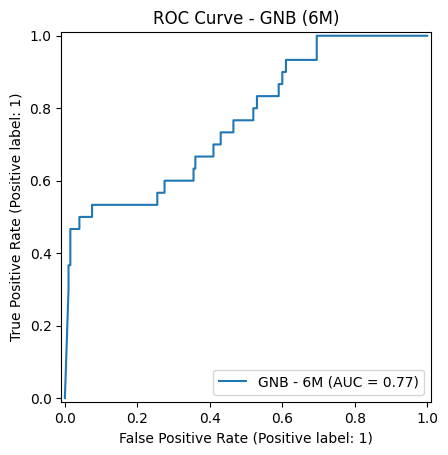

Saved complete historical predictions to naive_bayes_6M_complete_history.csv

Processing Gaussian Naive Bayes for 12M horizon
GNB Accuracy: 0.826
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       188
           1       0.54      0.36      0.43        42

    accuracy                           0.83       230
   macro avg       0.70      0.64      0.66       230
weighted avg       0.81      0.83      0.81       230



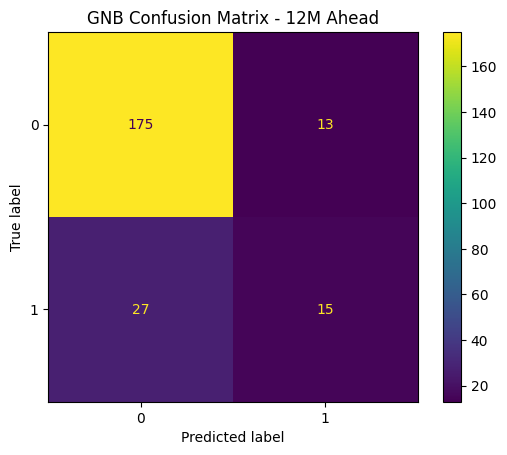

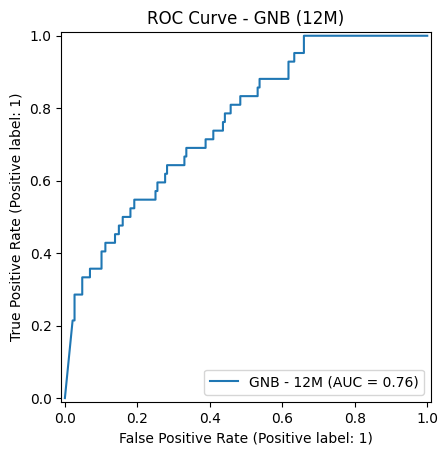

Saved complete historical predictions to naive_bayes_12M_complete_history.csv

Complete historical Gaussian Naive Bayes probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [123]:
#########################
# MODEL 6: GAUSSIAN NAIVE BAYES WITH IMPROVED PRIORS
#########################
print("\nProcessing Gaussian Naive Bayes with Improved Priors...")

# Dictionary to store results for dashboard format
gnb_results = {
    "model_name": "Gaussian Naive Bayes",
    "model_id": "naive_bayes",
    "color": "#00BCD4",  # Cyan color for the dashboard
    "predictions": {},
    "historical_data": []
}

# Compute optimal class priors from training data
best_gnb_priors_by_horizon = {}

for horizon in ['1M', '3M', '6M', '12M']:
    y_train = data_by_horizon[horizon]['y_train']
    class_counts = y_train.value_counts(normalize=True).to_dict()

    # Make sure both classes exist
    if 0 in class_counts and 1 in class_counts:
        priors = [class_counts.get(0, 0), class_counts.get(1, 0)]
        best_gnb_priors_by_horizon[horizon] = priors
    else:
        # Default priors if class counts are unbalanced
        best_gnb_priors_by_horizon[horizon] = [0.73, 0.27]

    print(f"Best Priors for {horizon}:", best_gnb_priors_by_horizon[horizon])

# Process each horizon
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing Gaussian Naive Bayes for {horizon} horizon")
    
    # Get data for this horizon - using scaled data
    X_train = data_by_horizon[horizon]['X_train_scaled']
    X_test = data_by_horizon[horizon]['X_test_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Train model with optimized priors
        priors = best_gnb_priors_by_horizon[horizon]
        gnb = GaussianNB(priors=priors)
        gnb.fit(X_train, y_train)
        
        # Make predictions
        y_pred = gnb.predict(X_test)
        test_probs = gnb.predict_proba(X_test)[:, 1]
        
        # Ensure probabilities are valid (0-1 range)
        test_probs = np.clip(test_probs, 0, 1)
        
        # Evaluate model performance
        acc = accuracy_score(y_test, y_pred)
        print(f"GNB Accuracy: {acc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"GNB Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Plot ROC Curve
        RocCurveDisplay.from_estimator(gnb, X_test, y_test, name=f'GNB - {horizon}')
        plt.title(f'ROC Curve - GNB ({horizon})')
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'naive_bayes_pred': test_probs
        })
        
        # Get historical predictions for training set
        train_probs = gnb.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are valid
        train_probs = np.clip(train_probs, 0, 1)
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'naive_bayes_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'naive_bayes_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        gnb_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            gnb_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in Naive Bayes model for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        gnb_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in gnb_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "naive_bayes_pred": record["naive_bayes_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('naive_bayes_complete_results.json', 'w') as f:
    json.dump({
        "model": gnb_results["model_name"],
        "model_id": gnb_results["model_id"],
        "color": gnb_results["color"],
        "predictions": gnb_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical Gaussian Naive Bayes probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing k-Nearest Neighbors with Cross-Validation...

Tuning kNN for 1M Horizon
Using default parameters: {'n_neighbors': 5, 'weights': 'distance'}

Tuning kNN for 3M Horizon
Using default parameters: {'n_neighbors': 5, 'weights': 'distance'}

Tuning kNN for 6M Horizon
Using default parameters: {'n_neighbors': 5, 'weights': 'distance'}

Tuning kNN for 12M Horizon
Using default parameters: {'n_neighbors': 5, 'weights': 'distance'}

Processing k-Nearest Neighbors for 1M horizon
kNN Accuracy: 0.943
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       210
           1       0.89      0.40      0.55        20

    accuracy                           0.94       230
   macro avg       0.92      0.70      0.76       230
weighted avg       0.94      0.94      0.93       230



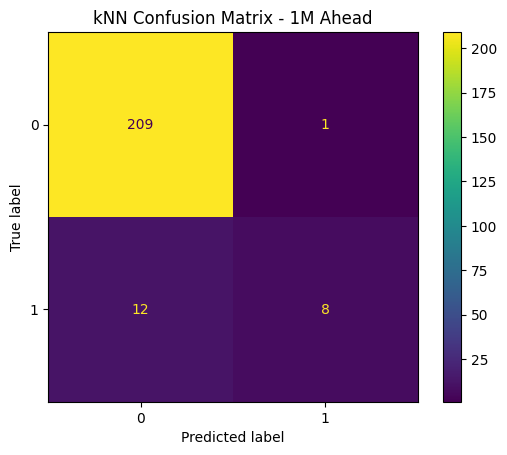

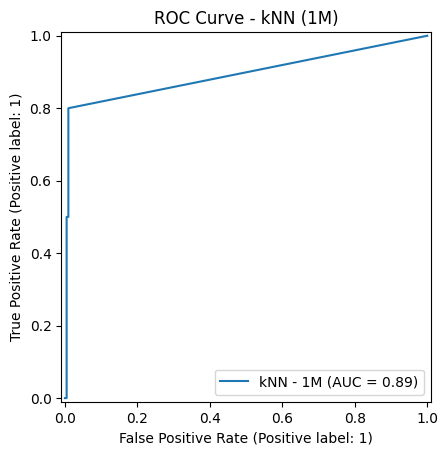

Saved complete historical predictions to knn_1M_complete_history.csv

Processing k-Nearest Neighbors for 3M horizon
kNN Accuracy: 0.926
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       206
           1       0.89      0.33      0.48        24

    accuracy                           0.93       230
   macro avg       0.91      0.66      0.72       230
weighted avg       0.92      0.93      0.91       230



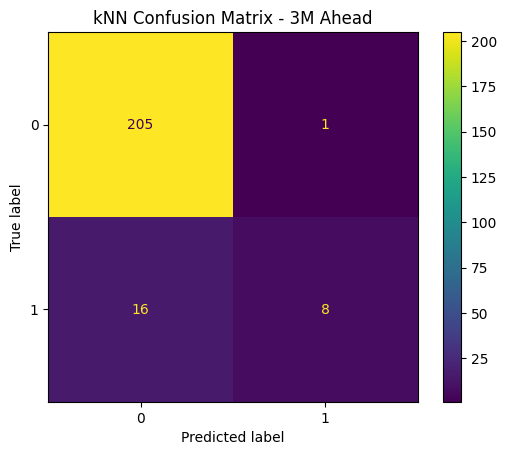

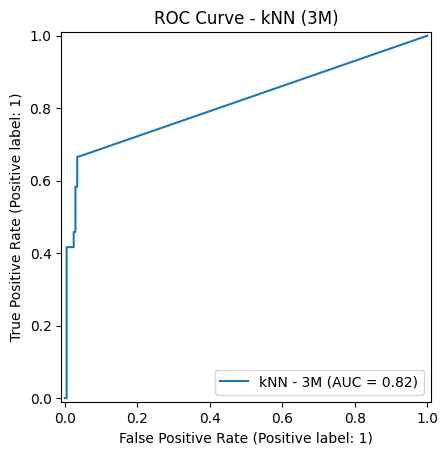

Saved complete historical predictions to knn_3M_complete_history.csv

Processing k-Nearest Neighbors for 6M horizon
kNN Accuracy: 0.900
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       200
           1       0.89      0.27      0.41        30

    accuracy                           0.90       230
   macro avg       0.89      0.63      0.68       230
weighted avg       0.90      0.90      0.88       230



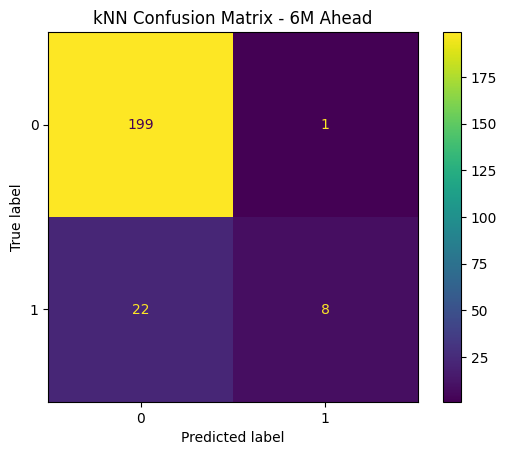

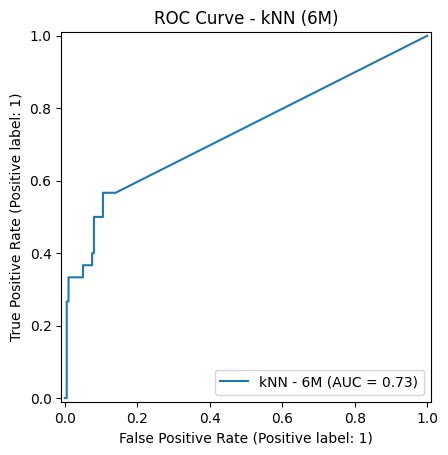

Saved complete historical predictions to knn_6M_complete_history.csv

Processing k-Nearest Neighbors for 12M horizon
kNN Accuracy: 0.835
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       188
           1       0.67      0.19      0.30        42

    accuracy                           0.83       230
   macro avg       0.76      0.58      0.60       230
weighted avg       0.81      0.83      0.79       230



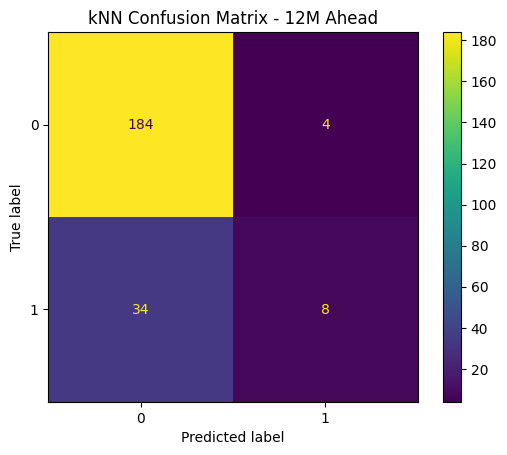

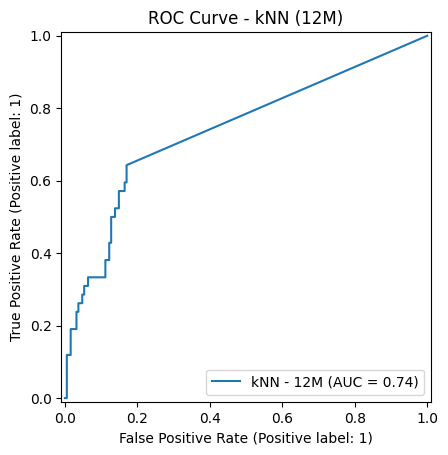

Saved complete historical predictions to knn_12M_complete_history.csv

Complete historical k-Nearest Neighbors probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [124]:
#########################
# MODEL 7: k-NEAREST NEIGHBORS WITH CROSS-VALIDATION
#########################
print("\nProcessing k-Nearest Neighbors with Cross-Validation...")

# Dictionary to store results for dashboard format
knn_results = {
    "model_name": "k-Nearest Neighbors",
    "model_id": "knn",
    "color": "#FFC107",  # Amber color for the dashboard
    "predictions": {},
    "historical_data": []
}

# First do cross-validation to find the best parameters
best_knn_params_by_horizon = {}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

tscv = TimeSeriesSplit(n_splits=5)

for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nTuning kNN for {horizon} Horizon")
    
    X_train = data_by_horizon[horizon]['X_train_scaled']
    y_train = data_by_horizon[horizon]['y_train']

    # Skip if any fold has only one class
    skip = False
    try:
        for _, test_idx in tscv.split(X_train):
            if len(np.unique(y_train.iloc[test_idx])) < 2:
                skip = True
                break
    except Exception as e:
        print(f"Error checking folds: {e}")
        skip = True
    
    if skip:
        best_knn_params_by_horizon[horizon] = {'n_neighbors': 5, 'weights': 'distance'}
        print("Using default parameters:", best_knn_params_by_horizon[horizon])
        continue

    try:
        # Time series CV for kNN
        knn = KNeighborsClassifier()
        
        grid_search = GridSearchCV(
            estimator=knn,
            param_grid=knn_param_grid,
            cv=tscv,
            scoring='balanced_accuracy',
            error_score='raise',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        
        print("Best Parameters:", grid_search.best_params_)
        print("Best Mean Balanced Accuracy:", grid_search.best_score_)
        
        best_knn_params_by_horizon[horizon] = grid_search.best_params_
    except Exception as e:
        print(f"Error in kNN CV for {horizon}: {e}")
        # Use default parameters if CV fails
        best_knn_params_by_horizon[horizon] = {'n_neighbors': 5, 'weights': 'distance'}
        print("Using default parameters:", best_knn_params_by_horizon[horizon])

# Now train with best parameters and generate predictions
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing k-Nearest Neighbors for {horizon} horizon")
    
    # Get data for this horizon
    X_train = data_by_horizon[horizon]['X_train_scaled']
    X_test = data_by_horizon[horizon]['X_test_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Train model with best parameters
        params = best_knn_params_by_horizon[horizon]
        knn = KNeighborsClassifier(**params)
        knn.fit(X_train, y_train)
        
        # Make predictions
        y_pred = knn.predict(X_test)
        test_probs = knn.predict_proba(X_test)[:, 1]
        
        # Ensure probabilities are valid (0-1 range)
        test_probs = np.clip(test_probs, 0, 1)
        
        # Evaluate model performance
        acc = accuracy_score(y_test, y_pred)
        print(f"kNN Accuracy: {acc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"kNN Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Plot ROC Curve
        RocCurveDisplay.from_estimator(knn, X_test, y_test, name=f'kNN - {horizon}')
        plt.title(f'ROC Curve - kNN ({horizon})')
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'knn_pred': test_probs
        })
        
        # Now, get historical predictions for the training set
        train_probs = knn.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are valid
        train_probs = np.clip(train_probs, 0, 1)
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'knn_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'knn_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        knn_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            knn_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in kNN model for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        knn_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in knn_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "knn_pred": record["knn_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('knn_complete_results.json', 'w') as f:
    json.dump({
        "model": knn_results["model_name"],
        "model_id": knn_results["model_id"],
        "color": knn_results["color"],
        "predictions": knn_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical k-Nearest Neighbors probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing AdaBoost with Cross-Validation...
Best Parameters (default): {'n_estimators': 100, 'learning_rate': 1.0}
Best Parameters (default): {'n_estimators': 100, 'learning_rate': 1.0}
Best Parameters (default): {'n_estimators': 100, 'learning_rate': 1.0}
Best Parameters (default): {'n_estimators': 100, 'learning_rate': 1.0}

Processing AdaBoost for 1M horizon
AdaBoost Accuracy: 0.961
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       210
           1       1.00      0.55      0.71        20

    accuracy                           0.96       230
   macro avg       0.98      0.78      0.84       230
weighted avg       0.96      0.96      0.96       230



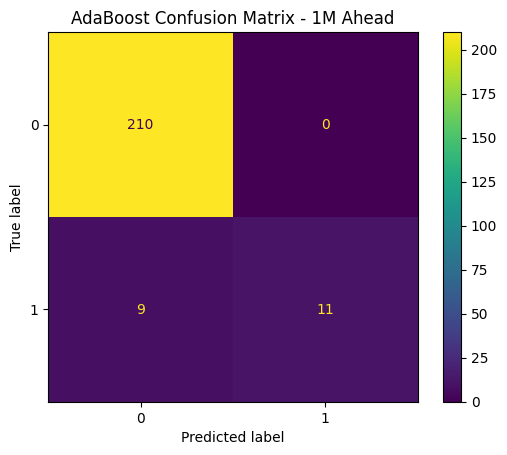

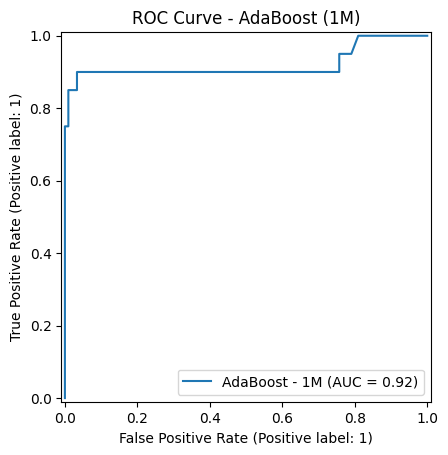

Saved complete historical predictions to adaboost_1M_complete_history.csv

Processing AdaBoost for 3M horizon
AdaBoost Accuracy: 0.961
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       206
           1       0.89      0.71      0.79        24

    accuracy                           0.96       230
   macro avg       0.93      0.85      0.88       230
weighted avg       0.96      0.96      0.96       230



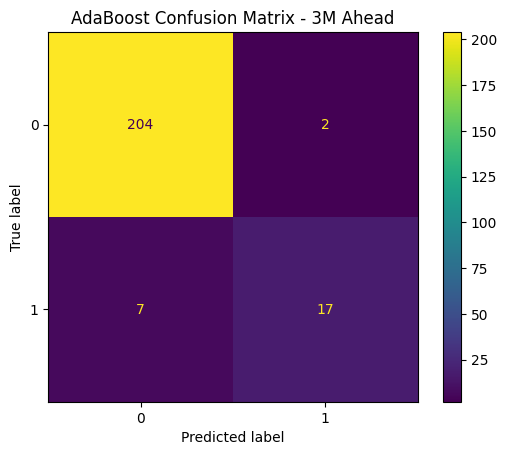

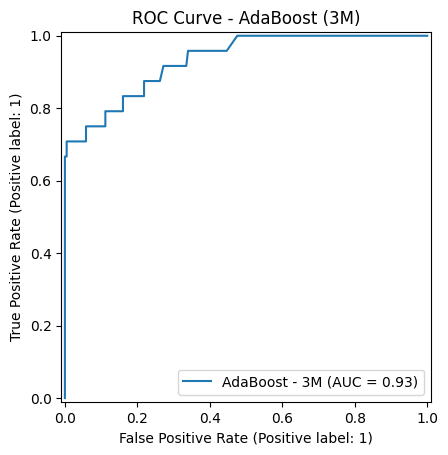

Saved complete historical predictions to adaboost_3M_complete_history.csv

Processing AdaBoost for 6M horizon
AdaBoost Accuracy: 0.891
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       200
           1       0.63      0.40      0.49        30

    accuracy                           0.89       230
   macro avg       0.77      0.68      0.71       230
weighted avg       0.88      0.89      0.88       230



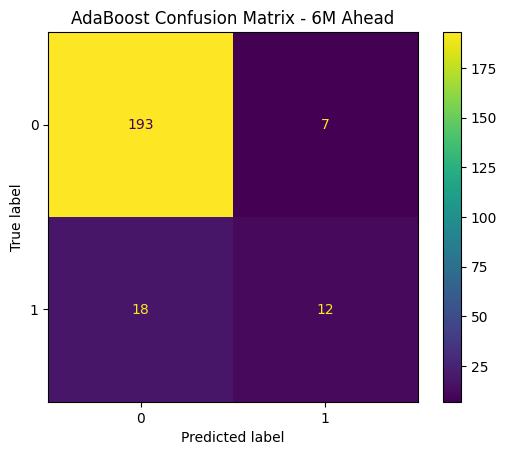

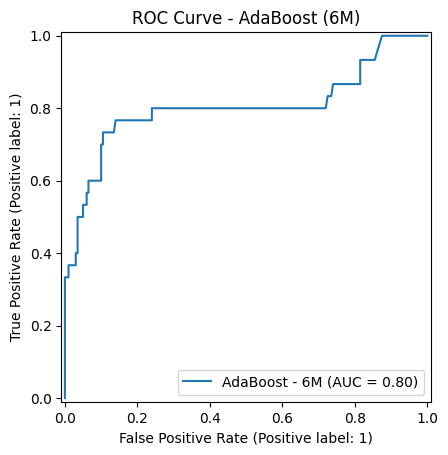

Saved complete historical predictions to adaboost_6M_complete_history.csv

Processing AdaBoost for 12M horizon
AdaBoost Accuracy: 0.852
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       188
           1       1.00      0.19      0.32        42

    accuracy                           0.85       230
   macro avg       0.92      0.60      0.62       230
weighted avg       0.87      0.85      0.81       230



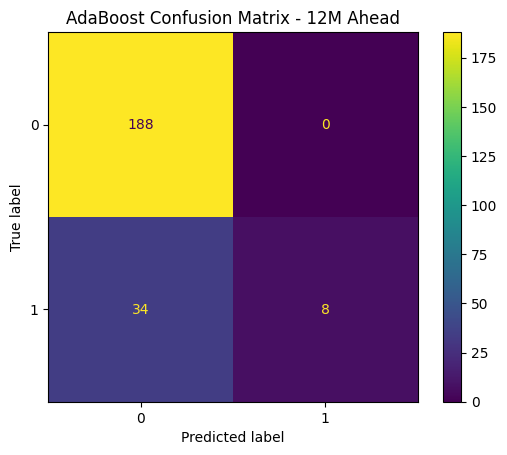

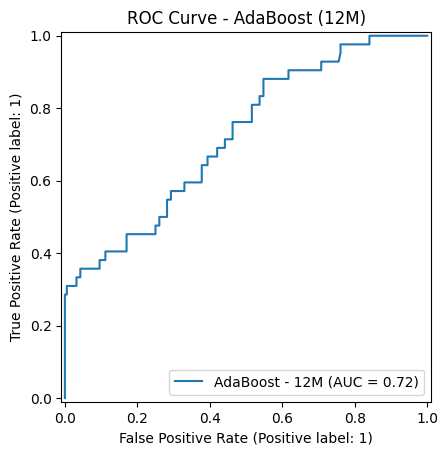

Saved complete historical predictions to adaboost_12M_complete_history.csv

Complete historical AdaBoost probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [125]:
#########################
# MODEL 8: ADABOOST WITH CROSS-VALIDATION
#########################
print("\nProcessing AdaBoost with Cross-Validation...")

# Dictionary to store results for dashboard format
ada_results = {
    "model_name": "AdaBoost",
    "model_id": "adaboost",
    "color": "#FF9800",  # Orange color for the dashboard
    "predictions": {},
    "historical_data": []
}

# First do cross-validation to find best parameters
best_ada_params_by_horizon = {}

ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.5, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

for horizon in ['1M', '3M', '6M', '12M']:
    X_train = data_by_horizon[horizon]['X_train_scaled']
    y_train = data_by_horizon[horizon]['y_train']

    # Skip if any fold has only one class
    skip = False
    try:
        for _, test_idx in tscv.split(X_train):
            if len(np.unique(y_train.iloc[test_idx])) < 2:
                skip = True
                break
    except Exception as e:
        print(f"Error checking folds: {e}")
        skip = True
    
    if skip:
        best_ada_params_by_horizon[horizon] = {'n_estimators': 100, 'learning_rate': 1.0}
        print("Best Parameters (default):", best_ada_params_by_horizon[horizon])
        continue

    print(f"\nTuning AdaBoost for {horizon} Horizon (scoring: Balanced Accuracy)")

    ada = AdaBoostClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=ada,
        param_grid=ada_param_grid,
        cv=tscv,
        scoring='balanced_accuracy',
        error_score='raise',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Mean Balanced Accuracy:", grid_search.best_score_)

    best_ada_params_by_horizon[horizon] = grid_search.best_params_

# Now train with best parameters and generate predictions
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing AdaBoost for {horizon} horizon")
    
    # Get data for this horizon - using scaled data 
    X_train = data_by_horizon[horizon]['X_train_scaled']
    X_test = data_by_horizon[horizon]['X_test_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Train model with best parameters
        params = best_ada_params_by_horizon[horizon]
        ada = AdaBoostClassifier(**params, random_state=42)
        ada.fit(X_train, y_train)
        
        # Make predictions
        y_pred = ada.predict(X_test)
        test_probs = ada.predict_proba(X_test)[:, 1]
        
        # Ensure probabilities are valid (0-1 range)
        test_probs = np.clip(test_probs, 0, 1)
        
        # Evaluate model performance
        acc = accuracy_score(y_test, y_pred)
        print(f"AdaBoost Accuracy: {acc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"AdaBoost Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Plot ROC Curve
        RocCurveDisplay.from_estimator(ada, X_test, y_test, name=f'AdaBoost - {horizon}')
        plt.title(f'ROC Curve - AdaBoost ({horizon})')
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'adaboost_pred': test_probs
        })
        
        # Get historical predictions for the training set
        train_probs = ada.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are valid
        train_probs = np.clip(train_probs, 0, 1)
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'adaboost_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'adaboost_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        ada_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            ada_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in AdaBoost model for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        ada_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in ada_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "adaboost_pred": record["adaboost_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('adaboost_complete_results.json', 'w') as f:
    json.dump({
        "model": ada_results["model_name"],
        "model_id": ada_results["model_id"],
        "color": ada_results["color"],
        "predictions": ada_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical AdaBoost probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing MLP Neural Network with Cross-Validation...
Best Parameters (default): {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.0001}
Best Parameters (default): {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.0001}
Best Parameters (default): {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.0001}
Best Parameters (default): {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.0001}

Processing MLP Neural Network for 1M horizon
MLP Accuracy: 0.948
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       210
           1       1.00      0.40      0.57        20

    accuracy                           0.95       230
   macro avg       0.97      0.70      0.77       230
weighted avg       0.95      0.95      0.94       230



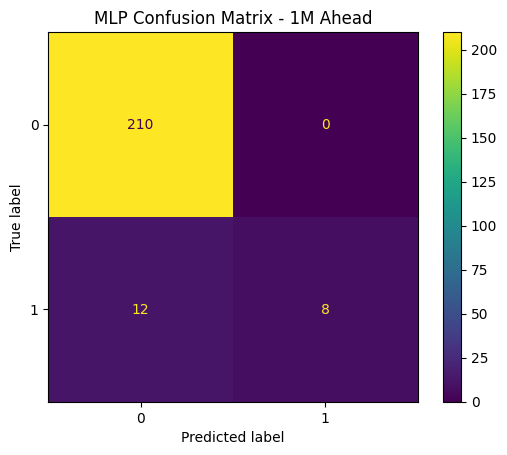

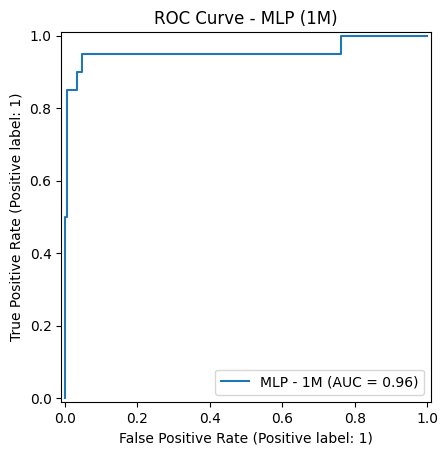

Saved complete historical predictions to neural_network_1M_complete_history.csv

Processing MLP Neural Network for 3M horizon
MLP Accuracy: 0.939
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       206
           1       0.92      0.46      0.61        24

    accuracy                           0.94       230
   macro avg       0.93      0.73      0.79       230
weighted avg       0.94      0.94      0.93       230



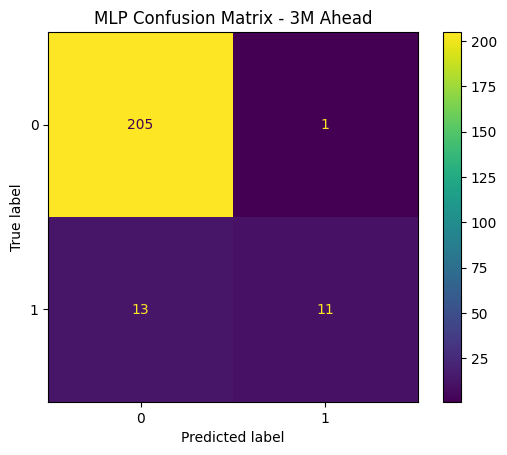

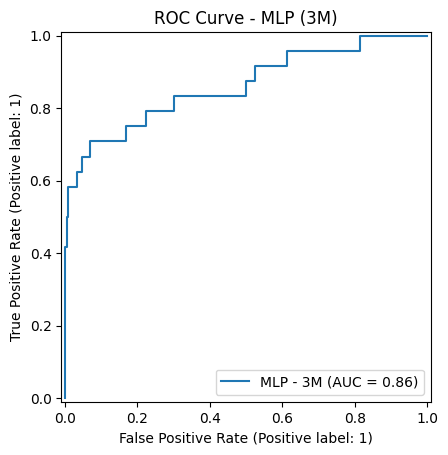

Saved complete historical predictions to neural_network_3M_complete_history.csv

Processing MLP Neural Network for 6M horizon
MLP Accuracy: 0.922
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       200
           1       0.83      0.50      0.62        30

    accuracy                           0.92       230
   macro avg       0.88      0.74      0.79       230
weighted avg       0.92      0.92      0.91       230



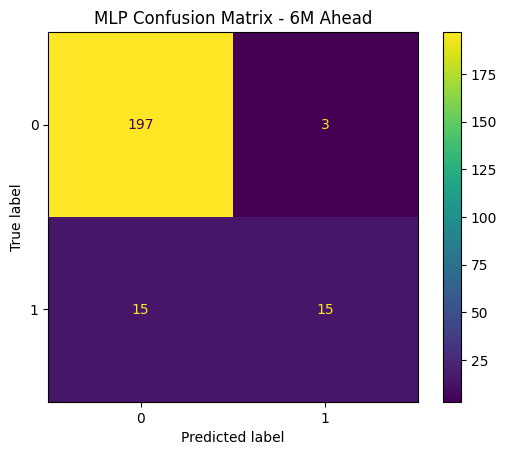

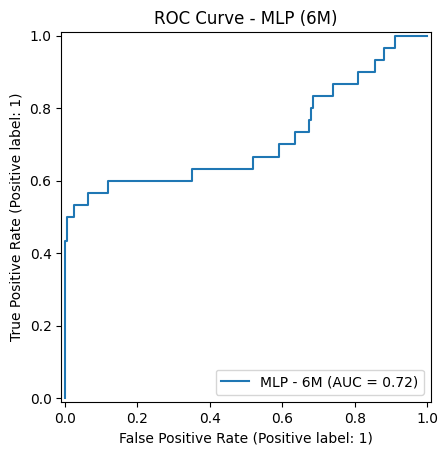

Saved complete historical predictions to neural_network_6M_complete_history.csv

Processing MLP Neural Network for 12M horizon
MLP Accuracy: 0.813
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       188
           1       0.49      0.43      0.46        42

    accuracy                           0.81       230
   macro avg       0.68      0.66      0.67       230
weighted avg       0.80      0.81      0.81       230



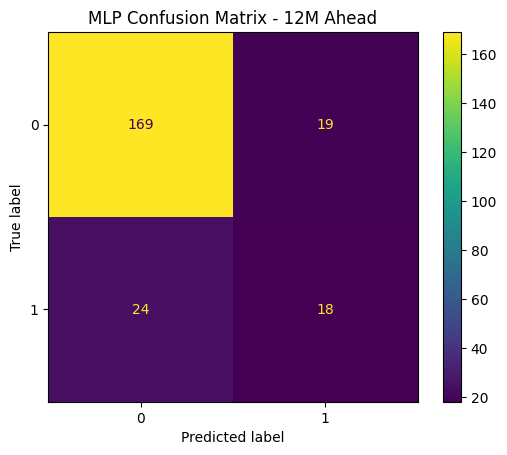

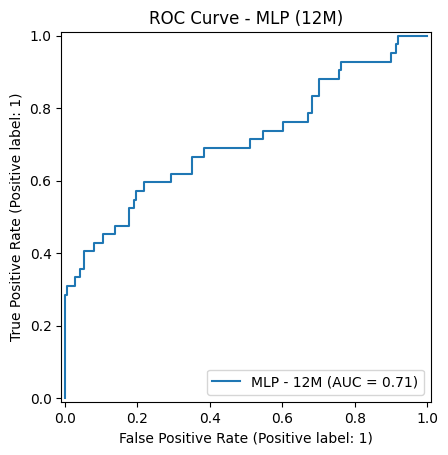

Saved complete historical predictions to neural_network_12M_complete_history.csv

Complete historical MLP Neural Network probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [126]:
#########################
# MODEL 9: MLP NEURAL NETWORK WITH CROSS-VALIDATION
#########################
print("\nProcessing MLP Neural Network with Cross-Validation...")

# Dictionary to store results for dashboard format
mlp_results = {
    "model_name": "Neural Network (MLP)",
    "model_id": "neural_network",
    "color": "#8BC34A",  # Light green color for the dashboard
    "predictions": {},
    "historical_data": []
}

# First do cross-validation to find best parameters
best_mlp_params_by_horizon = {}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

tscv = TimeSeriesSplit(n_splits=5)

for horizon in ['1M', '3M', '6M', '12M']:
    X_train = data_by_horizon[horizon]['X_train_scaled']
    y_train = data_by_horizon[horizon]['y_train']

    # Skip if any fold has only one class
    skip = False
    try:
        for _, test_idx in tscv.split(X_train):
            if len(np.unique(y_train.iloc[test_idx])) < 2:
                skip = True
                break
    except Exception as e:
        print(f"Error checking folds: {e}")
        skip = True
    
    if skip:
        best_mlp_params_by_horizon[horizon] = {
            'hidden_layer_sizes': (100, 50),
            'activation': 'relu',
            'alpha': 0.0001
        }
        print("Best Parameters (default):", best_mlp_params_by_horizon[horizon])
        continue

    print(f"\nTuning MLP for {horizon} Horizon (scoring: Balanced Accuracy)")

    mlp = MLPClassifier(max_iter=1000, random_state=42)

    grid_search = GridSearchCV(
        estimator=mlp,
        param_grid=mlp_param_grid,
        cv=tscv,
        scoring='balanced_accuracy',
        error_score='raise',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Mean Balanced Accuracy:", grid_search.best_score_)

    best_mlp_params_by_horizon[horizon] = grid_search.best_params_

# Now train with best parameters and generate predictions
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nProcessing MLP Neural Network for {horizon} horizon")
    
    # Get data for this horizon - using scaled data
    X_train = data_by_horizon[horizon]['X_train_scaled']
    X_test = data_by_horizon[horizon]['X_test_scaled']
    y_train = data_by_horizon[horizon]['y_train']
    y_test = data_by_horizon[horizon]['y_test']
    
    try:
        # Train model with best parameters
        params = best_mlp_params_by_horizon[horizon]
        mlp = MLPClassifier(**params, max_iter=1000, random_state=42)
        mlp.fit(X_train, y_train)
        
        # Make predictions
        y_pred = mlp.predict(X_test)
        test_probs = mlp.predict_proba(X_test)[:, 1]
        
        # Ensure probabilities are valid (0-1 range)
        test_probs = np.clip(test_probs, 0, 1)
        
        # Evaluate model performance
        acc = accuracy_score(y_test, y_pred)
        print(f"MLP Accuracy: {acc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"MLP Confusion Matrix - {horizon} Ahead")
        plt.show()
        
        # Plot ROC Curve
        RocCurveDisplay.from_estimator(mlp, X_test, y_test, name=f'MLP - {horizon}')
        plt.title(f'ROC Curve - MLP ({horizon})')
        plt.show()
        
        # Get test dates
        data.reset_index(inplace=True)
        test_indices = data[data['observation_date'] >= split_date].index[:len(y_test)]
        test_dates = data.loc[test_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert dates to strings for CSV output
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in test_dates]
        
        # Create output DataFrame for test set
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test.values,
            'neural_network_pred': test_probs
        })
        
        # Get historical predictions for the training set
        train_probs = mlp.predict_proba(X_train)[:, 1]
        
        # Ensure training probabilities are valid
        train_probs = np.clip(train_probs, 0, 1)
        
        # Get training dates
        data.reset_index(inplace=True)
        train_indices = data[data['observation_date'] < split_date].index[:len(y_train)]
        train_dates = data.loc[train_indices, 'observation_date'].values
        data.set_index('observation_date', inplace=True)
        
        # Convert train dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in train_dates]
        
        # Create output DataFrame for training set
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train.values,
            'neural_network_pred': train_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'neural_network_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(test_probs[-1])
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        mlp_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            mlp_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"Error in MLP Neural Network model for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        mlp_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in mlp_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "neural_network_pred": record["neural_network_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('neural_network_complete_results.json', 'w') as f:
    json.dump({
        "model": mlp_results["model_name"],
        "model_id": mlp_results["model_id"],
        "color": mlp_results["color"],
        "predictions": mlp_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical MLP Neural Network probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing ARIMAX Model...

ARIMAX for 1M Recession Prediction


/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arimax[features] = df_arimax[features].fillna(method='ffill')
/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arimax[features] = df_arimax[features].fillna(method='bfill')
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so in


ARIMAX for 3M Recession Prediction


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arimax[features] = df_arimax[features].fillna(method='ffill')
/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arimax[features] = df_arimax[features].fillna(method='bfill')
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information 


ARIMAX for 6M Recession Prediction


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arimax[features] = df_arimax[features].fillna(method='ffill')
/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arimax[features] = df_arimax[features].fillna(method='bfill')
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information 


ARIMAX for 12M Recession Prediction

Generating ARIMAX Predictions for 1M
ARIMAX Accuracy: 0.988 | ROC AUC: 0.985
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       221
         1.0       0.95      0.90      0.92        20

    accuracy                           0.99       241
   macro avg       0.97      0.95      0.96       241
weighted avg       0.99      0.99      0.99       241



/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


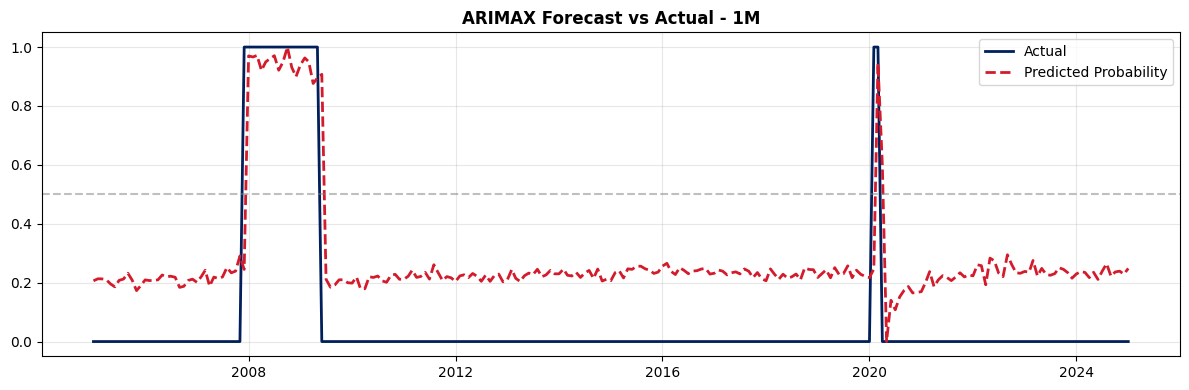

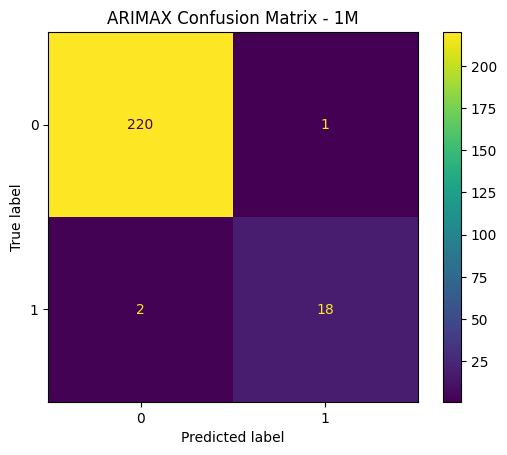

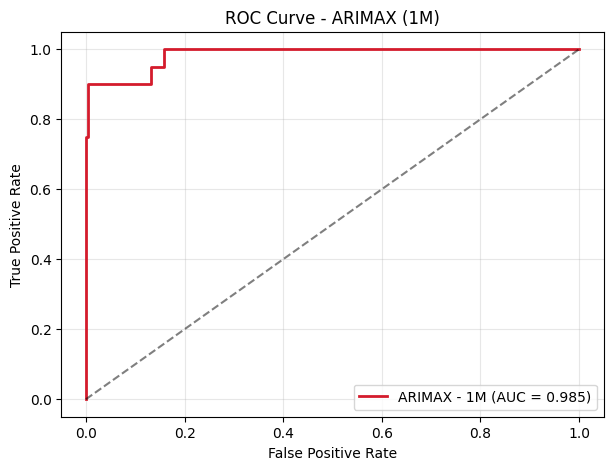

Saved complete historical predictions to arimax_1M_complete_history.csv

Generating ARIMAX Predictions for 3M
ARIMAX Accuracy: 0.967 | ROC AUC: 0.918
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       215
         1.0       0.90      0.75      0.82        24

    accuracy                           0.97       239
   macro avg       0.94      0.87      0.90       239
weighted avg       0.97      0.97      0.97       239



/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_prediction = float(test_probs[-1])


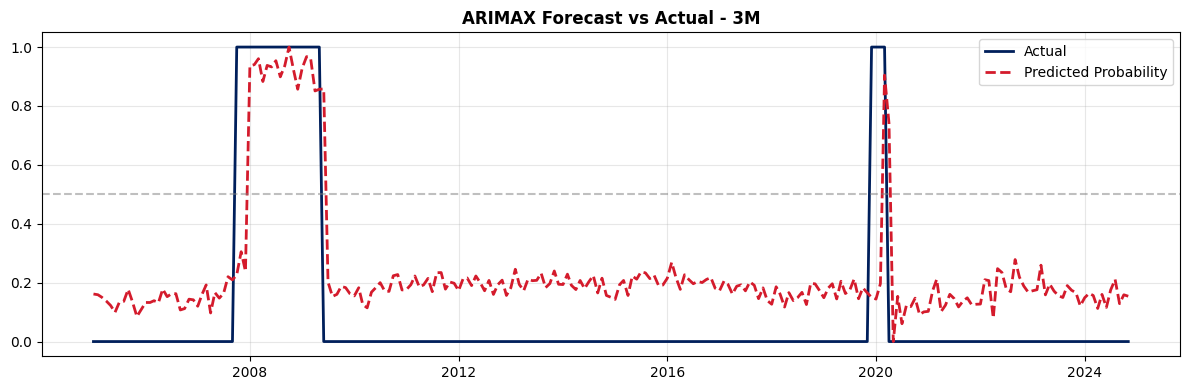

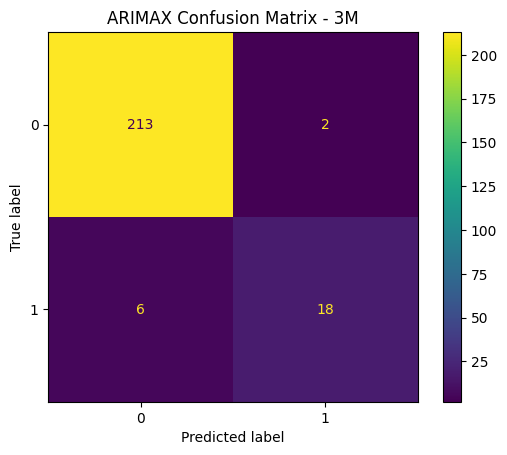

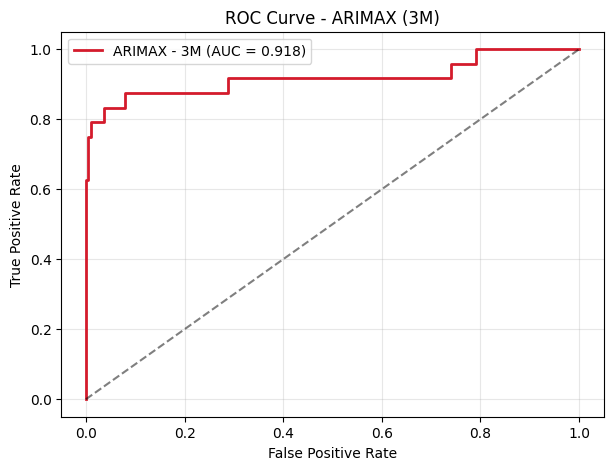

Saved complete historical predictions to arimax_3M_complete_history.csv

Generating ARIMAX Predictions for 6M
ARIMAX Accuracy: 0.941 | ROC AUC: 0.843
Classification Report:


/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_prediction = float(test_probs[-1])


              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       206
         1.0       0.90      0.60      0.72        30

    accuracy                           0.94       236
   macro avg       0.92      0.80      0.84       236
weighted avg       0.94      0.94      0.94       236



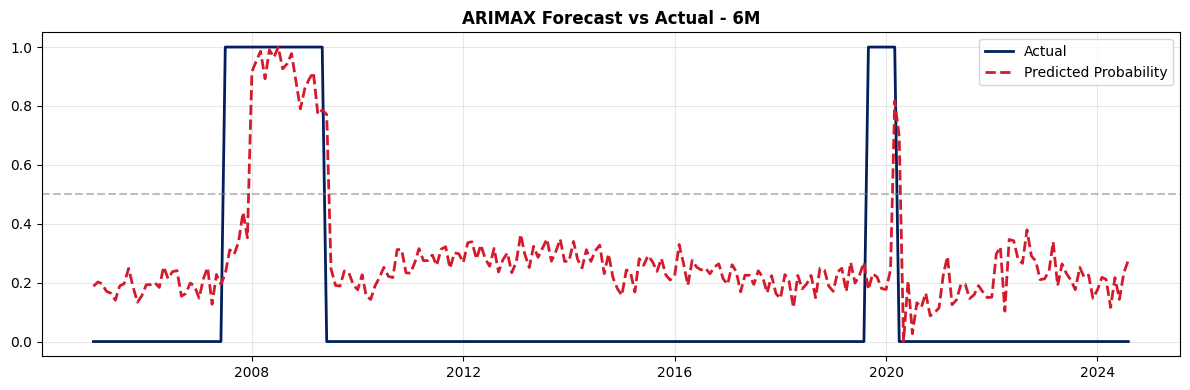

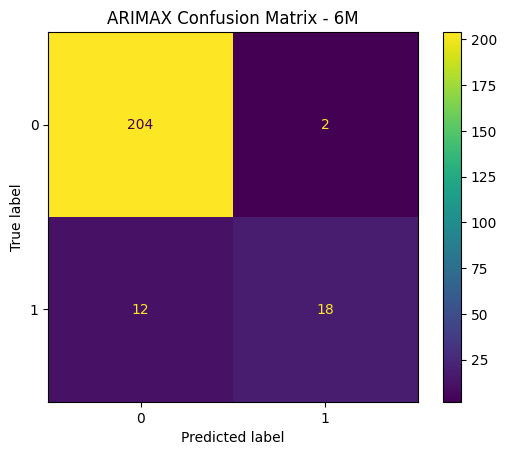

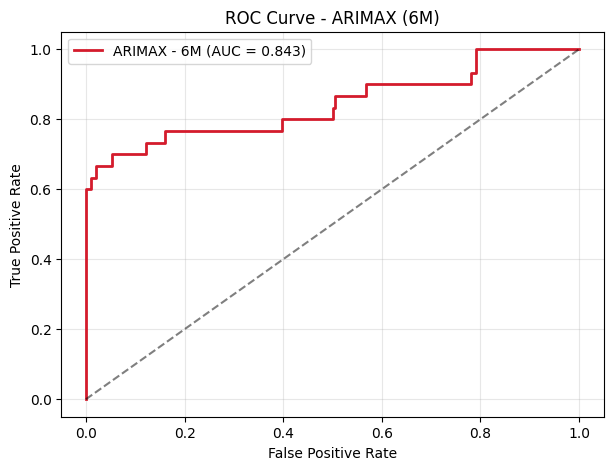

Saved complete historical predictions to arimax_6M_complete_history.csv

Generating ARIMAX Predictions for 12M


/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_prediction = float(test_probs[-1])


ARIMAX Accuracy: 0.887 | ROC AUC: 0.756
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       188
         1.0       0.86      0.45      0.59        42

    accuracy                           0.89       230
   macro avg       0.88      0.72      0.76       230
weighted avg       0.88      0.89      0.87       230



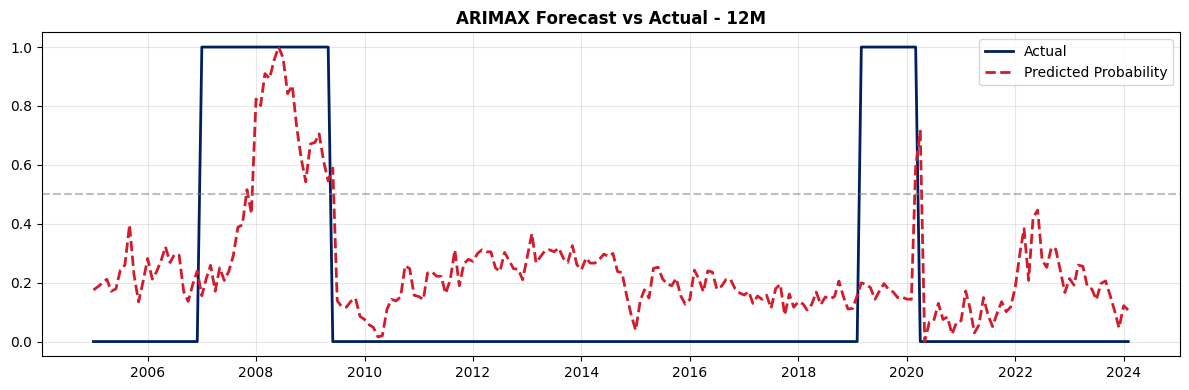

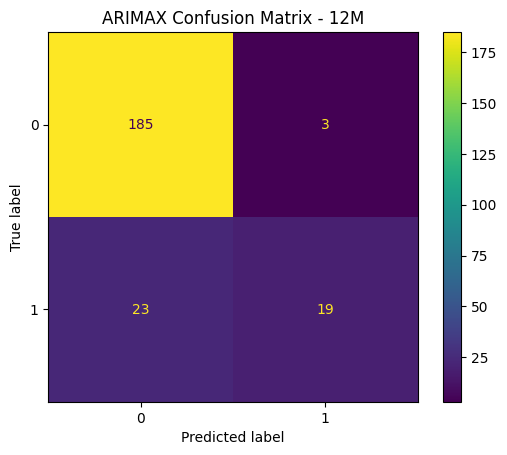

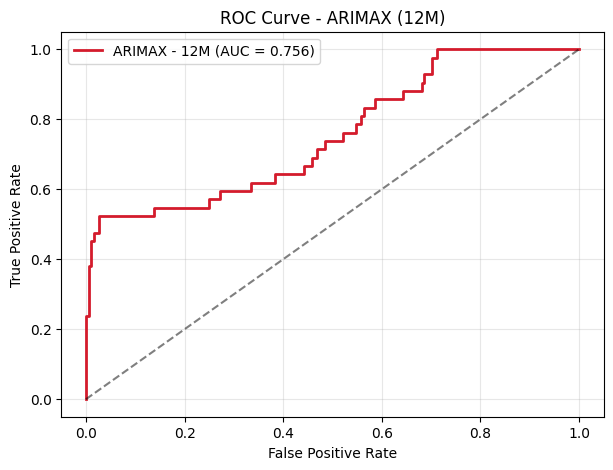

Saved complete historical predictions to arimax_12M_complete_history.csv

Complete historical ARIMAX probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


/var/folders/zc/bb05zyj92dn7mw596gdc5f4r0000gn/T/ipykernel_31097/2728111566.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_prediction = float(test_probs[-1])


In [127]:
#########################
# MODEL 10: ARIMAX
#########################
print("\nProcessing ARIMAX Model...")

# Dictionary to store results for dashboard format
arimax_results = {
    "model_name": "ARIMAX",
    "model_id": "arimax",
    "color": "#673AB7",  # Deep purple color for the dashboard
    "predictions": {},
    "historical_data": []
}

# Function to scale predictions to [0,1] range (maintaining order & AUC)
def scale_to_probability(predictions):
    """Scale predictions to [0,1] range while preserving order."""
    # Find min and max of predictions
    min_pred = np.min(predictions)
    max_pred = np.max(predictions)
    
    # Scale to [0,1] range
    if max_pred > min_pred:  # Avoid division by zero
        scaled_probs = (predictions - min_pred) / (max_pred - min_pred)
    else:
        scaled_probs = np.ones_like(predictions) * 0.5
    
    return scaled_probs

# Prepare full_data for ARIMAX models
if 'observation_date' not in full_data.columns:
    full_data_copy = full_data.copy()
    full_data_copy.reset_index(inplace=True)
else:
    full_data_copy = full_data.copy()

full_data_copy['observation_date'] = pd.to_datetime(full_data_copy['observation_date'])
full_data_copy.set_index('observation_date', inplace=True)
full_data_copy.sort_index(inplace=True)

# Store all ARIMAX results
arimax_results_by_horizon = {}
arimax_test_data_by_horizon = {}

# Run ARIMAX for each horizon
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\nARIMAX for {horizon} Recession Prediction")
    
    # Get features for this horizon
    features = feature_sets[horizon]
    target = f'REC{horizon}'
    
    # Filter and prepare data
    df_arimax = full_data_copy.dropna(subset=[target]).copy()
    df_arimax[features] = df_arimax[features].fillna(method='ffill')
    df_arimax[features] = df_arimax[features].fillna(method='bfill')
    
    if df_arimax[features].isna().any().any():
        print(f"Warning: Some NaN values remain after imputation for {horizon}")
        df_arimax[features] = df_arimax[features].fillna(0)
    
    try:
        # Split data
        endog = df_arimax[target]
        exog = df_arimax[features]
        endog_train = endog[endog.index < split_date]
        exog_train = exog[exog.index < split_date]
        endog_test = endog[endog.index >= split_date]
        exog_test = exog[exog.index >= split_date]
    
        # Fit ARIMAX model
        model = SARIMAX(endog_train, exog=exog_train, order=(1, 0, 0))
        results = model.fit(disp=False)
        
        arimax_results_by_horizon[horizon] = results
        arimax_test_data_by_horizon[horizon] = {
            'endog_test': endog_test,
            'exog_test': exog_test,
            'endog_train': endog_train,
            'exog_train': exog_train
        }
    except Exception as e:
        print(f"ARIMAX fitting failed for {horizon}: {e}")

# Generate predictions and evaluate
for horizon in ['1M', '3M', '6M', '12M']:
    if horizon not in arimax_results_by_horizon:
        print(f"No ARIMAX results for {horizon}, skipping...")
        continue
    
    print(f"\nGenerating ARIMAX Predictions for {horizon}")
    
    results = arimax_results_by_horizon[horizon]
    test_data = arimax_test_data_by_horizon[horizon]
    
    endog_test = test_data['endog_test']
    exog_test = test_data['exog_test']
    endog_train = test_data['endog_train']
    exog_train = test_data['exog_train']
    
    try:
        # Generate raw predictions for test set (post-2005)
        test_preds_raw = results.predict(start=exog_test.index[0], end=exog_test.index[-1], exog=exog_test)
        
        # For classification, use the raw values with 0.5 threshold
        y_pred_test = (test_preds_raw > 0.5).astype(int)
        
        # For probability output, scale to [0,1] range
        test_probs = scale_to_probability(test_preds_raw)
        
        # Now for in-sample predictions (pre-2005), also properly scaled
        train_preds_raw = results.predict(start=exog_train.index[0], end=exog_train.index[-1], exog=exog_train)
        train_probs = scale_to_probability(train_preds_raw)
        
        # Evaluate model on test set
        acc = accuracy_score(endog_test, y_pred_test)
        auc = roc_auc_score(endog_test, test_preds_raw)
        
        print(f"ARIMAX Accuracy: {acc:.3f} | ROC AUC: {auc:.3f}")
        print("Classification Report:")
        print(classification_report(endog_test, y_pred_test))
        
        # Plot time series visualization
        plt.figure(figsize=(12, 4))
        plt.plot(endog_test.index, endog_test.values, label='Actual', color='#001F5B', linewidth=2)
        plt.plot(test_preds_raw.index, test_probs, label='Predicted Probability', color='#D41B2C', linestyle='--', linewidth=2)
        plt.title(f'ARIMAX Forecast vs Actual - {horizon}', fontweight='bold')
        plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Plot Confusion Matrix
        cm = confusion_matrix(endog_test, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        ax.set_title(f"ARIMAX Confusion Matrix - {horizon}")
        plt.show()
        
        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(endog_test, test_preds_raw)
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'ARIMAX - {horizon} (AUC = {auc:.3f})', color='#D41B2C', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - ARIMAX ({horizon})')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Create data for dashboard 
        # Convert dates to strings
        train_dates = endog_train.index.strftime('%Y-%m-%d').tolist()
        test_dates = endog_test.index.strftime('%Y-%m-%d').tolist()
        
        # Create output DataFrames for train and test periods
        train_output_df = pd.DataFrame({
            'date': train_dates,
            'actual': endog_train.values,
            'arimax_pred': train_probs
        })
        
        test_output_df = pd.DataFrame({
            'date': test_dates,
            'actual': endog_test.values,
            'arimax_pred': test_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        full_output_df = full_output_df[full_output_df['date'] >= '1983-01-01']
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'arimax_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Calculate target date for current forecast using latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Store current prediction in results dictionary - use the latest prediction
        # Make sure to use the scaled probability for the prediction
        latest_prediction = float(test_probs[-1])
        
        arimax_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": latest_prediction
        }
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            arimax_results["historical_data"] = full_output_df.to_dict(orient='records')
    
    except Exception as e:
        print(f"ARIMAX failed for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        arimax_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# Convert our historical data into the dashboard's expected format
for record in arimax_results["historical_data"]:
    formatted_record = {
        "date": record["date"],
        "actual": record["actual"],
        "arimax_pred": record["arimax_pred"]
    }
    formatted_historical_data.append(formatted_record)

# Save formatted results for later combination with other models
with open('arimax_complete_results.json', 'w') as f:
    json.dump({
        "model": arimax_results["model_name"],
        "model_id": arimax_results["model_id"],
        "color": arimax_results["color"],
        "predictions": arimax_results["predictions"],
        "historical_data": formatted_historical_data
    }, f, indent=2)
    
print("\nComplete historical ARIMAX probabilities generated and saved!")
print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")


Processing LSTM Neural Network...

===== LSTM with NaN handling for 1M Recession Prediction =====
Epoch 1/50


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9022 - loss: 0.5051 - val_accuracy: 0.9130 - val_loss: 0.2931
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9599 - loss: 0.1863 - val_accuracy: 0.9130 - val_loss: 0.3125
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9231 - loss: 0.2841 - val_accuracy: 0.9130 - val_loss: 0.2844
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9427 - loss: 0.2192 - val_accuracy: 0.9130 - val_loss: 0.2793
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - loss: 0.2683 - val_accuracy: 0.9130 - val_loss: 0.2703
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9508 - loss: 0.1873 - val_accuracy: 0.9130 - val_loss: 0.2647
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9463 - loss: 0.1890 - val_accuracy: 0.9130 - val_loss: 0.2482
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9192 - loss: 0.2472 - val_accuracy: 0.9130 - val_loss: 0.2253
Ep

/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

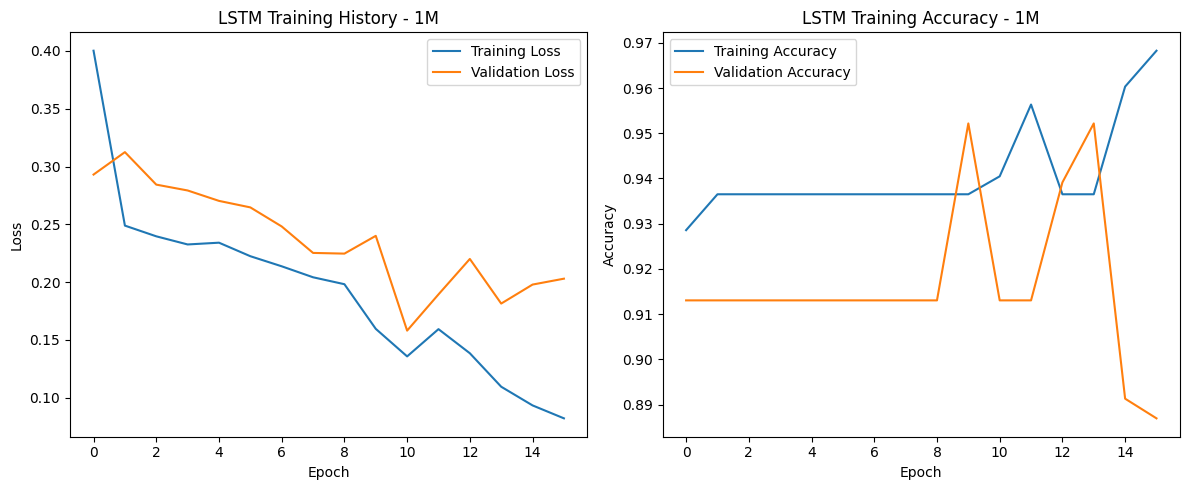

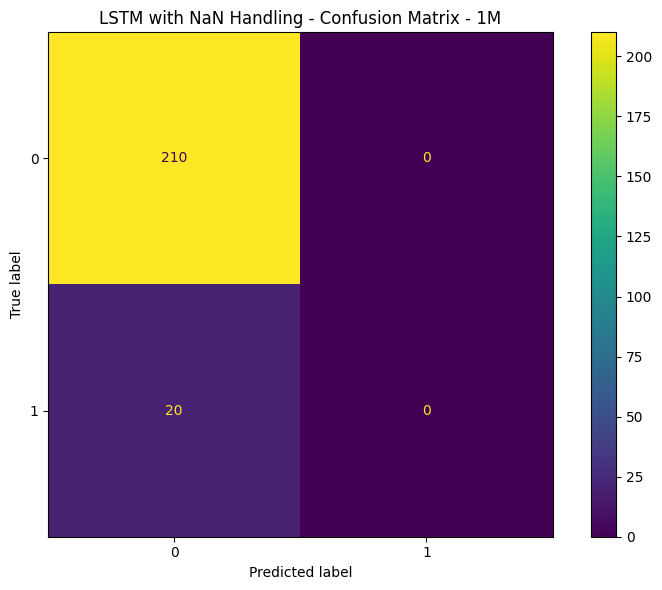

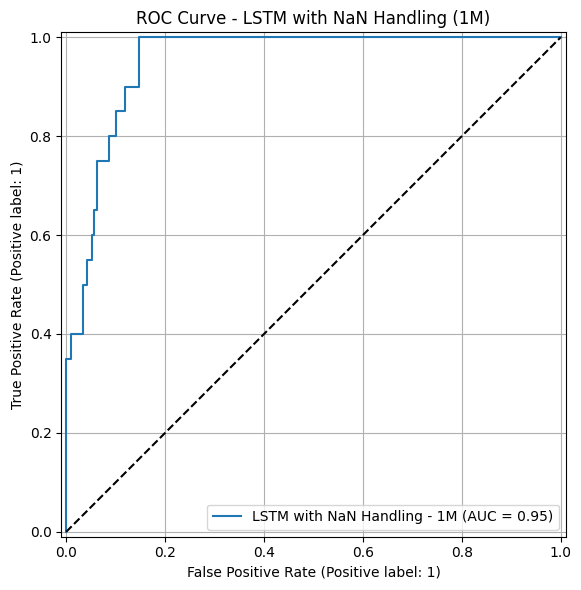

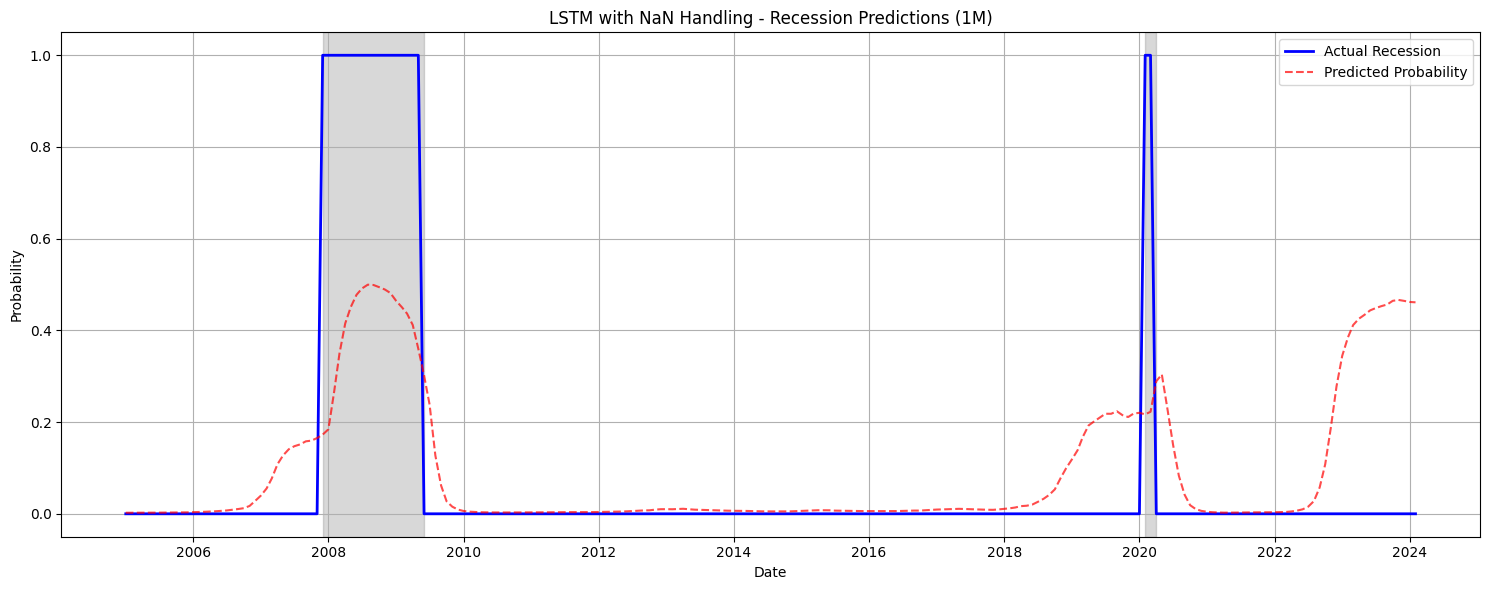



Saved complete historical predictions to lstm_1M_complete_history.csv

===== LSTM with NaN handling for 3M Recession Prediction =====
Epoch 1/50


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8644 - loss: 0.4953 - val_accuracy: 0.8957 - val_loss: 0.3405
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9280 - loss: 0.2576 - val_accuracy: 0.8957 - val_loss: 0.3465
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9016 - loss: 0.3273 - val_accuracy: 0.8957 - val_loss: 0.3197
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9142 - loss: 0.2698 - val_accuracy: 0.8957 - val_loss: 0.3240
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9206 - loss: 0.2385 - val_accuracy: 0.8957 - val_loss: 0.3032
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9009 - loss: 0.2292 - val_accuracy: 0.8957 - val_loss: 0.2990
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9540 - loss: 0.1404 - val_accuracy: 0.8957 - val_loss: 0.5504
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9452 - loss: 0.1041 - val_accuracy: 0.8957 - val_loss: 0.5927
E

/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

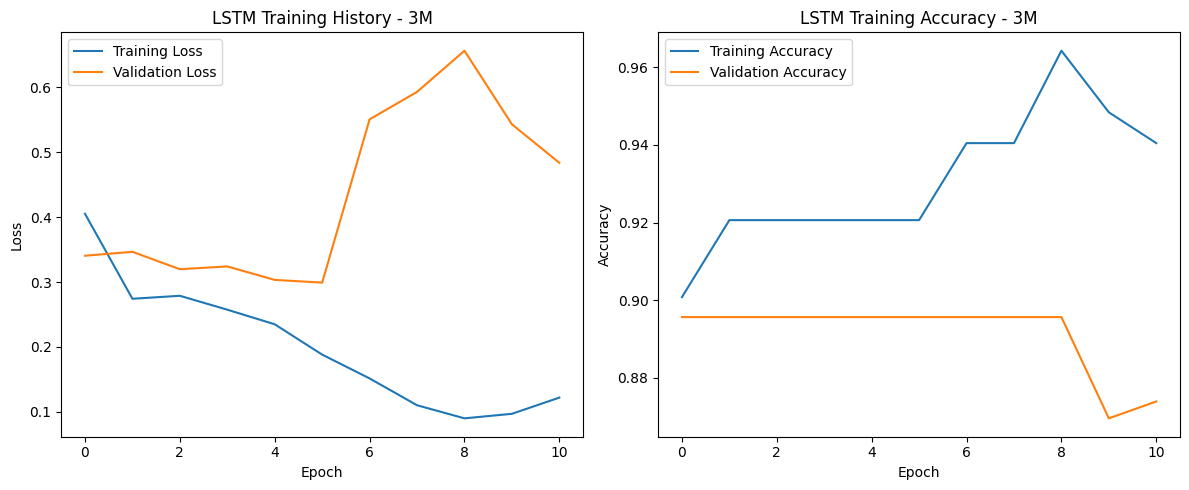

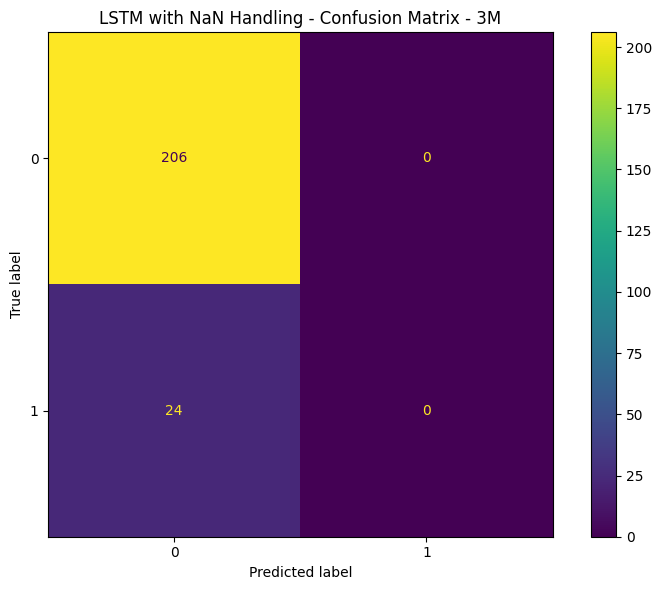

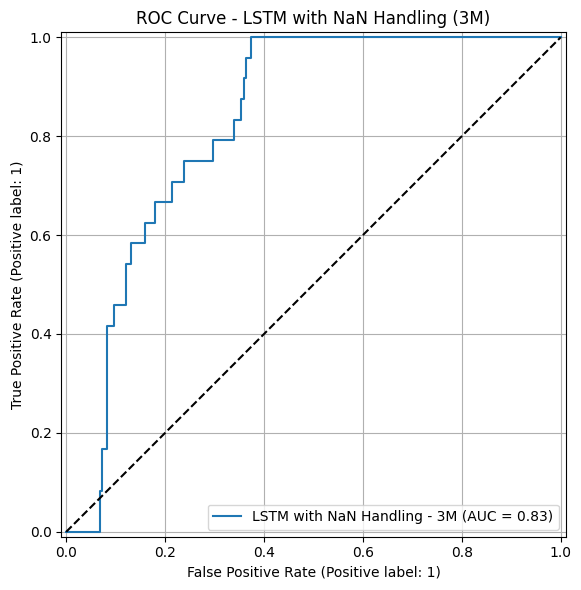

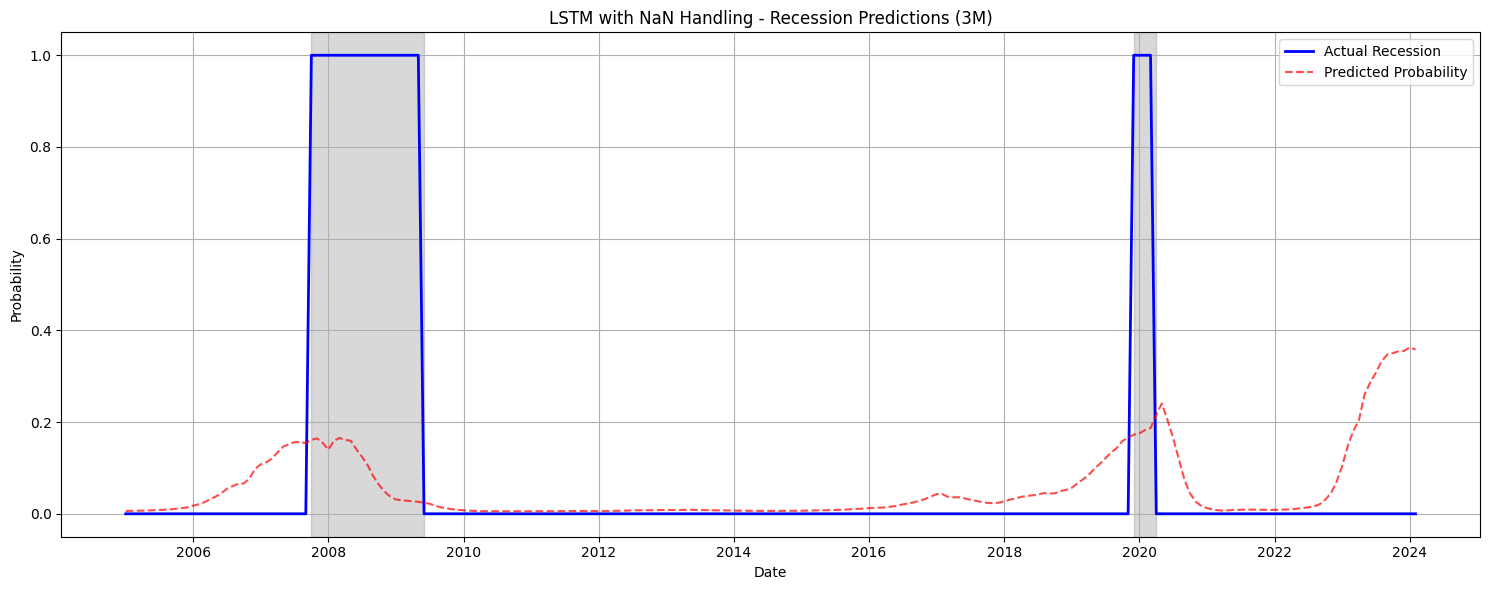



Saved complete historical predictions to lstm_3M_complete_history.csv

===== LSTM with NaN handling for 6M Recession Prediction =====
Epoch 1/50


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6361 - loss: 0.6186 - val_accuracy: 0.8696 - val_loss: 0.3889
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9252 - loss: 0.2850 - val_accuracy: 0.8696 - val_loss: 0.4084
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8852 - loss: 0.3576 - val_accuracy: 0.8696 - val_loss: 0.3735
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8989 - loss: 0.3127 - val_accuracy: 0.8696 - val_loss: 0.3607
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9005 - loss: 0.2885 - val_accuracy: 0.8696 - val_loss: 0.3265
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8959 - loss: 0.2566 - val_accuracy: 0.8696 - val_loss: 0.2545
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9339 - loss: 0.1243 - val_accuracy: 0.7826 - val_loss: 0.2881
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9532 - loss: 0.1332 - val_accuracy: 0.8174 - val_loss: 0.3055
Ep

/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

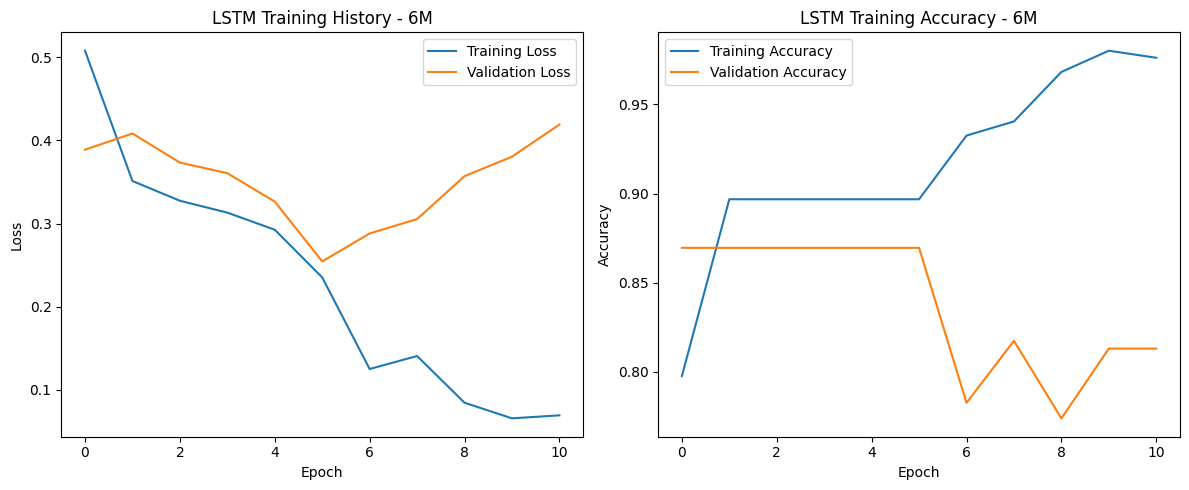

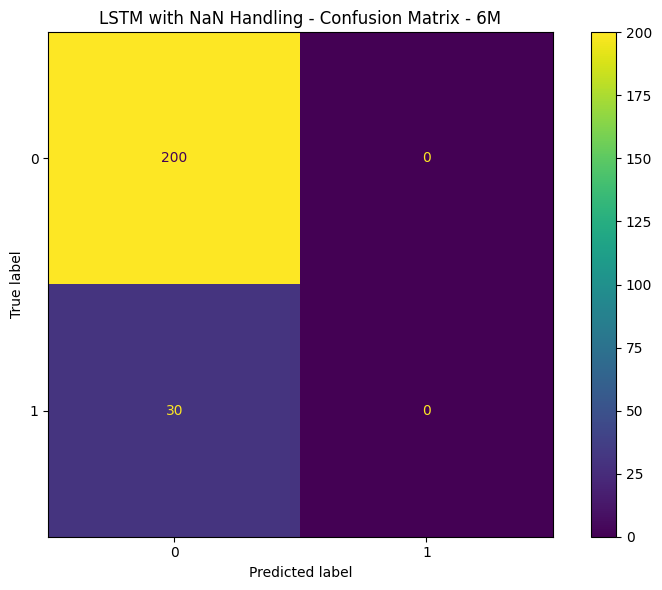

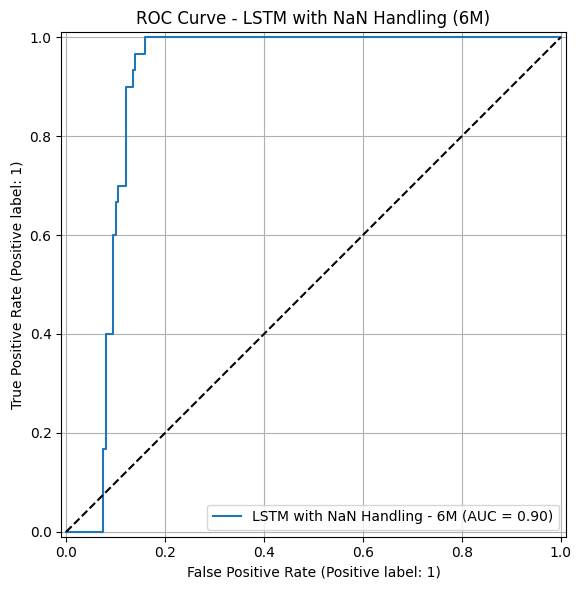

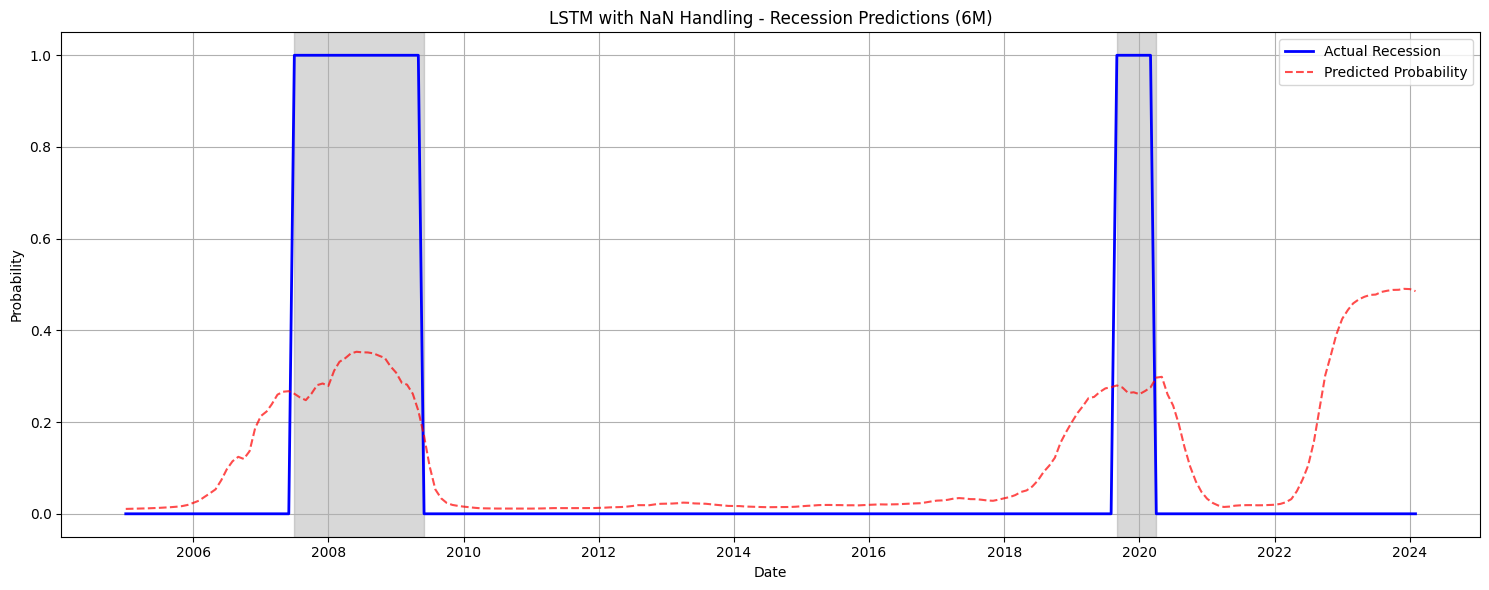



Saved complete historical predictions to lstm_6M_complete_history.csv

===== LSTM with NaN handling for 12M Recession Prediction =====
Epoch 1/50


/Users/tamir/Documents/MyCode/NEU/ML/6140project/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6673 - loss: 0.5994 - val_accuracy: 0.8174 - val_loss: 0.4807
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8523 - loss: 0.4115 - val_accuracy: 0.8174 - val_loss: 0.4632
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8226 - loss: 0.4412 - val_accuracy: 0.8174 - val_loss: 0.4448
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8649 - loss: 0.3439 - val_accuracy: 0.8174 - val_loss: 0.4142
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8715 - loss: 0.2576 - val_accuracy: 0.8000 - val_loss: 0.4052
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9087 - loss: 0.1793 - val_accuracy: 0.8174 - val_loss: 0.3836
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9670 - loss: 0.1097 - val_accuracy: 0.8348 - val_loss: 0.4126
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9547 - loss: 0.1213 - val_accuracy: 0.8261 - val_loss: 0.4311
Ep

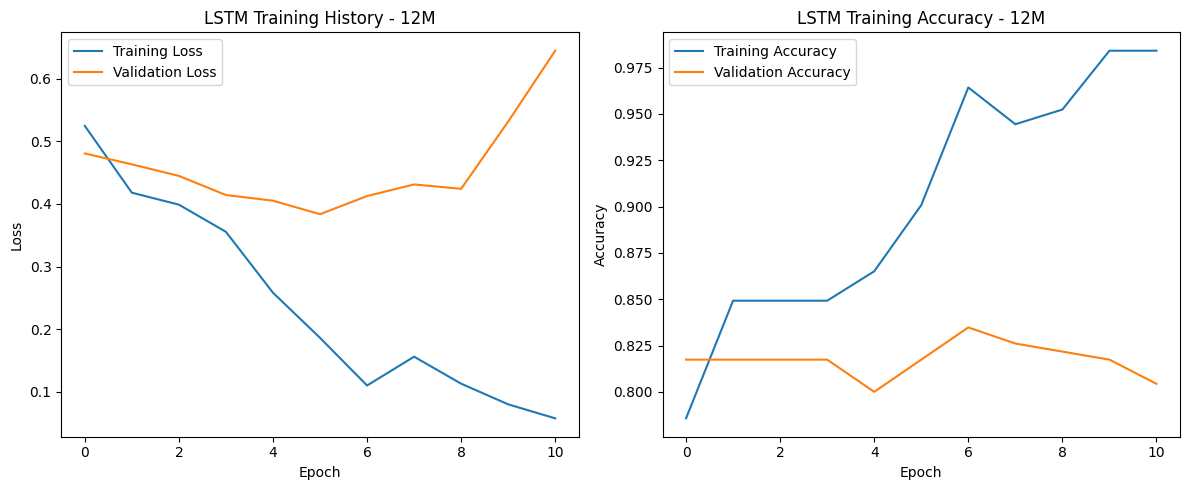

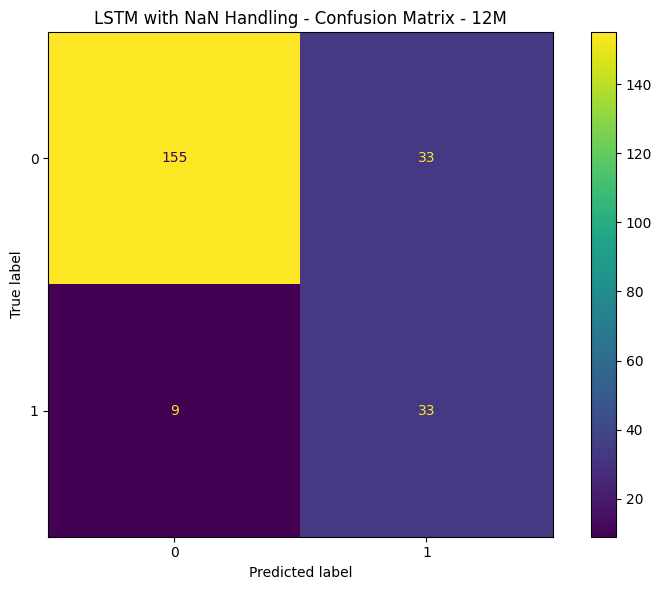

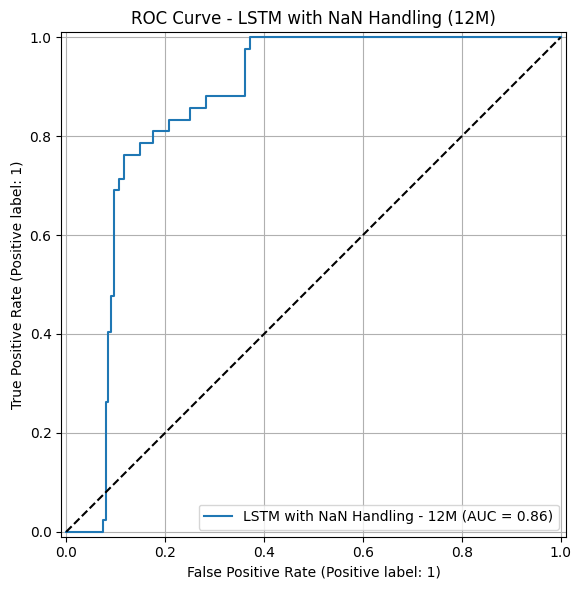

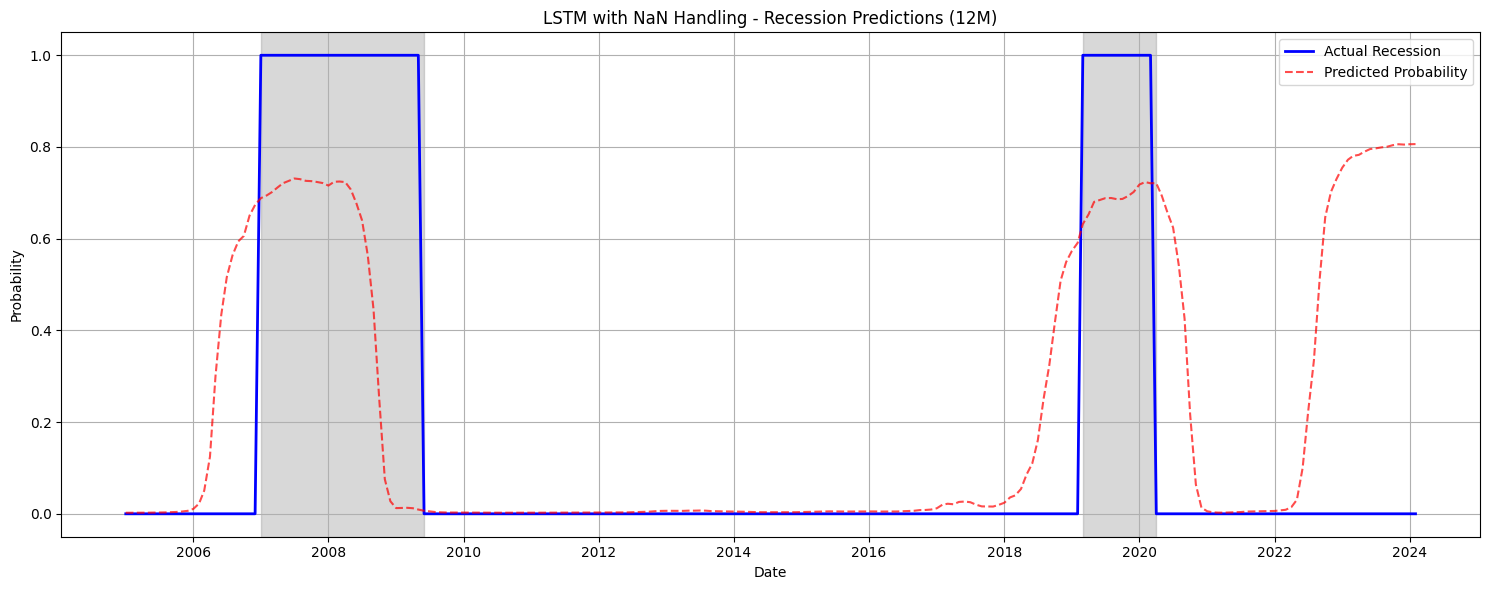


Analyzing Feature Importance for LSTM Model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Baseline ROC AUC: 0.8633
Calculating importance for USREC...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Calculating importance for UNRATE...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Calculating importance for AHETPI...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Calculating importance for PERMIT...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

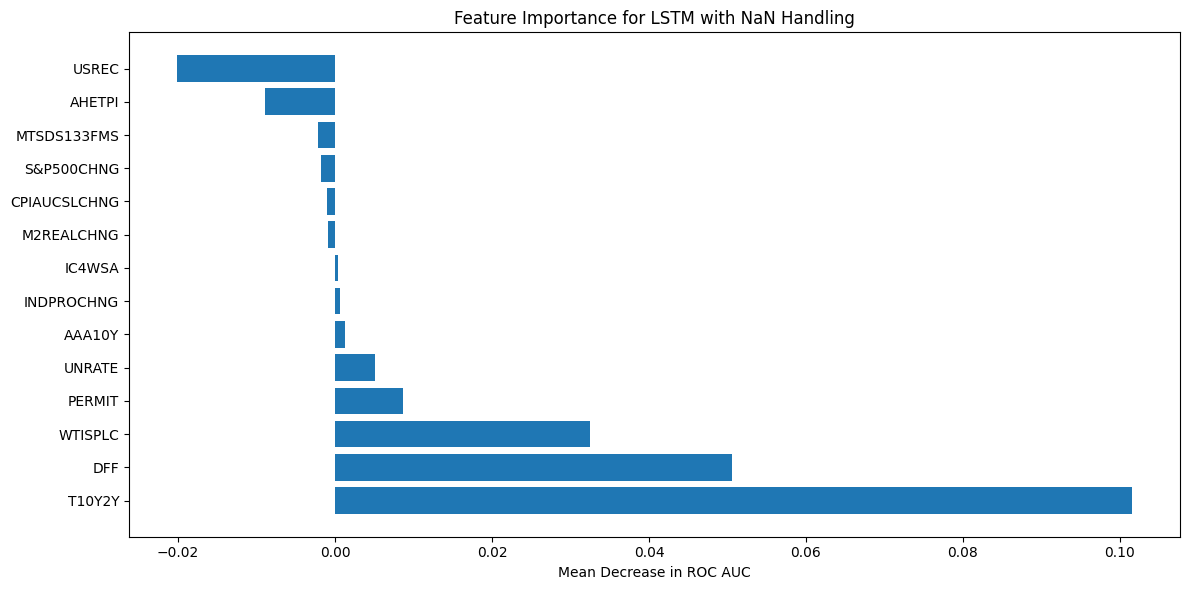

Top 5 Most Important Features:
    Feature  Importance
9    T10Y2Y    0.101570
7       DFF    0.050633
11  WTISPLC    0.032548
3    PERMIT    0.008612
1    UNRATE    0.005041


Saved complete historical predictions to lstm_12M_complete_history.csv

Complete historical LSTM probabilities generated and saved!
This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.


In [128]:
#########################
# MODEL 11: LSTM NEURAL NETWORK 
#########################
print("\nProcessing LSTM Neural Network...")

# Dictionary to store results for dashboard format
lstm_results = {
    "model_name": "LSTM Neural Network",
    "model_id": "lstm",
    "color": "#009688",  # Teal color for the dashboard
    "predictions": {},
    "historical_data": []
}

# Function to scale features while preserving NaN values
def scale_with_nans(df, features):
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    
    # For each feature, scale non-NaN values and keep NaNs as NaNs
    for col in features:
        mask = ~df[col].isna()  # Create mask of non-NaN values
        if mask.sum() > 0:  # If there are non-NaN values
            df_scaled.loc[mask, col] = scaler.fit_transform(
                df.loc[mask, col].values.reshape(-1, 1)
            ).flatten()
    
    return df_scaled

# Function to create sequences while preserving NaN values
def create_lstm_sequences_with_nans(data, features, target_col, sequence_length):
    X, y, dates = [], [], []
    for i in range(sequence_length, len(data)):
        seq = data[features].iloc[i-sequence_length:i].values
        # Only create sequences where target is not NaN
        if not pd.isna(data[target_col].iloc[i]):
            X.append(seq)  # Keep NaNs in features
            y.append(data[target_col].iloc[i])
            dates.append(data.index[i])
    return np.array(X), np.array(y), np.array(dates)

# Set parameters
sequence_length = 12

# Loop through horizons
for horizon in ['1M', '3M', '6M', '12M']:
    print(f"\n===== LSTM with NaN handling for {horizon} Recession Prediction =====")
    
    target_col = f'REC{horizon}'
    features = feature_sets[horizon]
    
    try:
        # Use original data instead of undefined data_lstm
        df_filtered = data.dropna(subset=[target_col]).copy()
        
        # Scale features while preserving NaN pattern
        df_scaled = scale_with_nans(df_filtered, features)
        df_scaled[target_col] = df_filtered[target_col]
    
        # Create sequences (with NaNs preserved)
        X, y, date_index = create_lstm_sequences_with_nans(df_scaled, features, target_col, sequence_length)
        
        # Replace NaN with 0 (which will be masked)
        X_filled = np.nan_to_num(X, nan=0.0)
        
        # Time-based train-test split
        split_idx = np.where(date_index >= pd.Timestamp(split_date))[0][0]
        X_train, X_test = X_filled[:split_idx], X_filled[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        date_train = date_index[:split_idx]
        date_test = date_index[split_idx:]
        
        # Build model with masking layer
        model = Sequential()
        model.add(Masking(mask_value=0.0, input_shape=(X.shape[1], X.shape[2])))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Add early stopping for better training
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Fit the model with more epochs but with early stopping
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=16,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict 
        y_pred_prob = model.predict(X_test).ravel()
        y_pred_class = (y_pred_prob > 0.5).astype(int)
        
        # Make predictions for training set as well
        train_probs = model.predict(X_train).ravel()
        
        # Evaluate
        acc = accuracy_score(y_test, y_pred_class)
        auc = roc_auc_score(y_test, y_pred_prob)
        
        print(f"LSTM with NaN Handling - Accuracy: {acc:.3f} | ROC AUC: {auc:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_class))
        
        # Create a DataFrame with actual and predicted values for visualization
        results_df = pd.DataFrame({
            'Date': date_test,
            'Actual': y_test,
            'Predicted_Prob': y_pred_prob,
            'Predicted_Class': y_pred_class
        }).set_index('Date')
        
        # --- VISUALIZATIONS ---
        
        # 1. Plot Training History
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'LSTM Training History - {horizon}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'LSTM Training Accuracy - {horizon}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 2. Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_class)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax)
        ax.set_title(f"LSTM with NaN Handling - Confusion Matrix - {horizon}")
        plt.tight_layout()
        plt.show()
        
        # 3. Plot ROC Curve
        fig, ax = plt.subplots(figsize=(8, 6))
        RocCurveDisplay.from_predictions(
            y_test, y_pred_prob, 
            name=f"LSTM with NaN Handling - {horizon}",
            ax=ax
        )
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - LSTM with NaN Handling ({horizon})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # 4. Time Series Visualization of Predictions
        plt.figure(figsize=(15, 6))
        plt.plot(results_df.index, results_df['Actual'], 'b-', label='Actual Recession', linewidth=2)
        plt.plot(results_df.index, results_df['Predicted_Prob'], 'r--', label='Predicted Probability', alpha=0.7)
        
        # Shade recession periods
        recession_periods = []
        in_recession = False
        recession_start = None
        
        for date, is_recession in zip(results_df.index, results_df['Actual']):
            if is_recession == 1 and not in_recession:
                recession_start = date
                in_recession = True
            elif is_recession == 0 and in_recession:
                recession_periods.append((recession_start, date))
                in_recession = False
        
        # Add the last recession if it extends to the end of the data
        if in_recession:
            recession_periods.append((recession_start, results_df.index[-1]))
        
        # Shade the recession periods
        for start, end in recession_periods:
            plt.axvspan(start, end, color='gray', alpha=0.3)
        
        plt.title(f'LSTM with NaN Handling - Recession Predictions ({horizon})')
        plt.xlabel('Date')
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # 5. Feature Importance Analysis (manual implementation)
        if horizon == '12M':  # Only do this for one horizon to save time
            print("\nAnalyzing Feature Importance for LSTM Model...")
            
            # Calculate baseline score
            baseline_pred = model.predict(X_test).ravel()
            baseline_score = roc_auc_score(y_test, baseline_pred)
            print(f"Baseline ROC AUC: {baseline_score:.4f}")
            
            # Manual permutation importance
            feature_importance = {}
            n_repeats = 5  # Number of permutation rounds
            
            # For each feature (axis) in the input data
            for feature_idx in range(X_test.shape[2]):
                scores = []
                feature_name = features[feature_idx]
                print(f"Calculating importance for {feature_name}...")
                
                # Repeat multiple times to get stable results
                for _ in range(n_repeats):
                    # Create a copy of the test data
                    X_permuted = X_test.copy()
                    
                    # Shuffle values for the current feature across all sequences and timesteps
                    # We keep the temporal structure but mix values between different sequences
                    for t in range(X_permuted.shape[1]):  # For each timestep
                        # Get values at this timestep and feature
                        vals = X_permuted[:, t, feature_idx].copy()
                        
                        # Permute the values
                        np.random.shuffle(vals)
                        
                        # Put back the permuted values
                        X_permuted[:, t, feature_idx] = vals
                    
                    # Predict with the permuted data
                    perm_pred = model.predict(X_permuted).ravel()
                    perm_score = roc_auc_score(y_test, perm_pred)
                    
                    # Calculate importance as decrease in performance
                    importance = baseline_score - perm_score
                    scores.append(importance)
                
                # Average importance across repeats
                feature_importance[feature_name] = np.mean(scores)
            
            # Create DataFrame for easier analysis and plotting
            importance_df = pd.DataFrame({
                'Feature': list(feature_importance.keys()),
                'Importance': list(feature_importance.values())
            }).sort_values('Importance', ascending=False)
            
            # Plot feature importance
            plt.figure(figsize=(12, 6))
            plt.barh(importance_df['Feature'], importance_df['Importance'])
            plt.title('Feature Importance for LSTM with NaN Handling')
            plt.xlabel('Mean Decrease in ROC AUC')
            plt.tight_layout()
            plt.show()
            
            print("Top 5 Most Important Features:")
            print(importance_df.head(5))
        
        print("\n" + "="*70 + "\n")
        
        # Now format data for dashboard
        # Convert dates to strings
        train_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in date_train]
        test_dates_str = [pd.Timestamp(d).strftime('%Y-%m-%d') for d in date_test]
        
        # Create DataFrames for train and test
        train_output_df = pd.DataFrame({
            'date': train_dates_str,
            'actual': y_train,
            'lstm_pred': train_probs
        })
        
        test_output_df = pd.DataFrame({
            'date': test_dates_str,
            'actual': y_test,
            'lstm_pred': y_pred_prob  # Use y_pred_prob instead of undefined test_probs
        })
        
        # Combine train and test results for complete historical series
        full_output_df = pd.concat([train_output_df, test_output_df])
        
        # Filter to include only data from 1983 onwards AND ensure we're not including future dates where actual values aren't available
        full_output_df['date'] = pd.to_datetime(full_output_df['date'])
        
        # Only include dates up to the latest date with actual values
        latest_actual_date = data.reset_index().dropna(subset=['USREC'])['observation_date'].max()
        
        # Filter to include only data from 1983 onwards and up to the latest date with actual values
        full_output_df = full_output_df[(full_output_df['date'] >= '1983-01-01') & 
                                        (full_output_df['date'] <= latest_actual_date)]
        
        full_output_df['date'] = full_output_df['date'].dt.strftime('%Y-%m-%d')
        
        # Save to CSV
        output_file = f'lstm_{horizon}_complete_history.csv'
        full_output_df.to_csv(output_file, index=False)
        print(f"Saved complete historical predictions to {output_file}")
        
        # Add this horizon's complete history to our collection
        if horizon == '6M':  # Let's use 6M as our default for historical data
            lstm_results["historical_data"] = full_output_df.to_dict(orient='records')
        
        # Calculate target date based on latest data date
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        # Adjust year if month exceeds 12
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        # Ensure the final probability is valid (between 0 and 1)
        final_prob = float(y_pred_prob[-1])  # Use y_pred_prob instead of undefined test_probs
        final_prob = max(0, min(1, final_prob))
        
        # Store current prediction in results dictionary
        lstm_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": final_prob
        }
    except Exception as e:
        print(f"LSTM failed for {horizon}: {e}")
        # Provide fallback predictions in case of failure
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_data_date.month + months_ahead
        target_year = latest_data_date.year
        
        while target_month > 12:
            target_month -= 12
            target_year += 1
        
        target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
        
        lstm_results["predictions"][horizon] = {
            "target_date": target_date,
            "probability": 0.5  # Neutral probability as fallback
        }

# Format data for the dashboard's JSON structure
formatted_historical_data = []

# If we have historical data, format it for the dashboard
if lstm_results["historical_data"]:
    # Convert our historical data into the dashboard's expected format
    for record in lstm_results["historical_data"]:
        formatted_record = {
            "date": record["date"],
            "actual": record["actual"],
            "lstm_pred": record["lstm_pred"]
        }
        formatted_historical_data.append(formatted_record)

    # Save formatted results for later combination with other models
    with open('lstm_complete_results.json', 'w') as f:
        json.dump({
            "model": lstm_results["model_name"],
            "model_id": lstm_results["model_id"],
            "color": lstm_results["color"],
            "predictions": lstm_results["predictions"],
            "historical_data": formatted_historical_data
        }, f, indent=2)
    
    print("\nComplete historical LSTM probabilities generated and saved!")
    print("This includes all recession periods from 1983 to present, including dot-com bubble, 2008 crisis, and COVID-19.")
else:
    print("\nWarning: LSTM failed to generate usable results for the dashboard.")

In [131]:
#########################
# FINAL STEP: COMBINE ALL MODELS INTO DASHBOARD DATA
#########################
print("\nGenerating final dashboard data (recession_prediction_data.json)...")

# Improved code to combine all model results into a single JSON file for the dashboard
import json
import pandas as pd
import os
from datetime import datetime

# List of all model JSON files we've created (with fallback file names)
models_to_process = [
    {"name": "Logistic Regression", "id": "logistic_regression", "color": "#FF5733", 
     "files": ["logistic_regression_complete_results.json", "logistic_regression_results.json"]},
    {"name": "Random Forest", "id": "random_forest", "color": "#4CAF50", 
     "files": ["random_forest_complete_results.json", "random_forest_results.json"]},
    {"name": "XGBoost", "id": "xgboost", "color": "#3F51B5", 
     "files": ["xgboost_complete_results.json", "xgboost_results.json"]},
    {"name": "Ensemble (Avg)", "id": "ensemble_avg", "color": "#9C27B0", 
     "files": ["ensemble_complete_results.json", "ensemble_results.json"]},
    {"name": "Support Vector Machine", "id": "svm", "color": "#E91E63", 
     "files": ["svm_complete_results.json", "svm_results.json"]},
    {"name": "Gaussian Naive Bayes", "id": "naive_bayes", "color": "#00BCD4", 
     "files": ["naive_bayes_complete_results.json", "naive_bayes_results.json"]},
    {"name": "k-Nearest Neighbors", "id": "knn", "color": "#FFC107", 
     "files": ["knn_complete_results.json", "knn_results.json"]},
    {"name": "AdaBoost", "id": "adaboost", "color": "#FF9800", 
     "files": ["adaboost_complete_results.json", "adaboost_results.json"]},
    {"name": "Neural Network (MLP)", "id": "neural_network", "color": "#8BC34A", 
     "files": ["neural_network_complete_results.json", "neural_network_results.json"]},
    {"name": "ARIMAX", "id": "arimax", "color": "#673AB7", 
     "files": ["arimax_complete_results.json", "arimax_results.json"]},
    {"name": "LSTM Neural Network", "id": "lstm", "color": "#009688", 
     "files": ["lstm_complete_results.json", "lstm_results.json"]}
]

# Define time horizons
horizons = ['1M', '3M', '6M', '12M']

# Get the latest data date from a model file or from the source data
def get_latest_data_date():
    # First try to extract from one of the model files
    for model_info in models_to_process:
        for file_path in model_info["files"]:
            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        model_data = json.load(f)
                        if "predictions" in model_data and "6M" in model_data["predictions"]:
                            if "target_date" in model_data["predictions"]["6M"]:
                                target_date = model_data["predictions"]["6M"]["target_date"]
                                # Extract the base date (6 months prior to target)
                                target_dt = datetime.strptime(target_date, '%Y-%m-%d')
                                month = target_dt.month - 6
                                year = target_dt.year
                                while month <= 0:
                                    month += 12
                                    year -= 1
                                return f"{year}-{month:02d}-{target_dt.day:02d}"
                except Exception:
                    pass
    
    # Use the latest data date defined earlier if available
    if 'latest_data_date' in globals():
        return latest_data_date.strftime('%Y-%m-%d')
    
    # Fallback to current date with a 3-month lag (typical data lag)
    current_date = datetime.now()
    month = current_date.month - 3
    year = current_date.year
    if month <= 0:
        month += 12
        year -= 1
    return f"{year}-{month:02d}-{current_date.day:02d}"

# Initialize the dashboard data structure
dashboard_data = {
    "models": [],
    "predictions": {
        "1M": {"targetDate": "", "models": {}},
        "3M": {"targetDate": "", "models": {}},
        "6M": {"targetDate": "", "models": {}},
        "12M": {"targetDate": "", "models": {}}
    },
    "historicalData": [],
    "lastUpdated": datetime.now().strftime('%Y-%m-%d')
}

# Process individual CSVs if JSON files aren't available
def try_process_csv_files(model_info, latest_data_date_str):
    predictions = {}
    historical_data = []
    
    latest_data_date = datetime.strptime(latest_data_date_str, '%Y-%m-%d')
    
    # Try to read the 6M horizon CSV file for historical data
    csv_file = f"{model_info['id']}_6M_complete_history.csv"
    if os.path.exists(csv_file):
        try:
            df = pd.read_csv(csv_file)
            
            # Add records to historical data
            for _, row in df.iterrows():
                # Ensure probability values are valid
                pred_col = f"{model_info['id']}_pred"
                if pred_col not in row:
                    # Try alternate column names
                    alternate_cols = [
                        f"{model_info['name'].lower().replace(' ', '_')}_pred",
                        "probability"
                    ]
                    for alt_col in alternate_cols:
                        if alt_col in row:
                            pred_col = alt_col
                            break
                
                if pred_col in row:
                    # Ensure probability is in valid range
                    prob_value = row[pred_col]
                    if not pd.isna(prob_value):
                        prob_value = float(prob_value)
                        prob_value = max(0, min(1, prob_value))
                    
                    historical_data.append({
                        "date": row['date'],
                        "actual": row['actual'],
                        f"{model_info['id']}_pred": prob_value
                    })
            
            # Get the latest prediction for each horizon
            for horizon in horizons:
                horizon_file = f"{model_info['id']}_{horizon}_complete_history.csv"
                if os.path.exists(horizon_file):
                    try:
                        horizon_df = pd.read_csv(horizon_file)
                        if not horizon_df.empty:
                            # Set target date based on latest data date
                            months_ahead = int(horizon.replace('M', ''))
                            target_month = latest_data_date.month + months_ahead
                            target_year = latest_data_date.year
                            while target_month > 12:
                                target_month -= 12
                                target_year += 1
                            target_date = f"{target_year}-{target_month:02d}-{latest_data_date.day:02d}"
                            
                            # Get last prediction value and ensure it's in valid range
                            last_row = horizon_df.iloc[-1]
                            pred_col = f"{model_info['id']}_pred"
                            if pred_col not in last_row:
                                # Try alternate column names
                                alternate_cols = [
                                    f"{model_info['name'].lower().replace(' ', '_')}_pred",
                                    "probability"
                                ]
                                for alt_col in alternate_cols:
                                    if alt_col in last_row:
                                        pred_col = alt_col
                                        break
                            
                            if pred_col in last_row:
                                pred_value = float(last_row[pred_col])
                                # Ensure value is in valid range
                                pred_value = max(0, min(1, pred_value))
                                
                                predictions[horizon] = {
                                    "target_date": target_date,
                                    "probability": pred_value
                                }
                    except Exception as e:
                        print(f"Error processing CSV file {horizon_file}: {e}")
            
            print(f"Processed CSV files for {model_info['name']}")
            return predictions, historical_data
        except Exception as e:
            print(f"Error processing CSV file {csv_file}: {e}")
    
    return None, None

# Get the latest data date
latest_data_date_str = get_latest_data_date()
print(f"Using latest data date: {latest_data_date_str}")

# Load and process each model
for model_info in models_to_process:
    model_data = None
    
    # Try all possible file names
    for file_path in model_info["files"]:
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    model_data = json.load(f)
                print(f"Processed {file_path}")
                break
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    
    # If no JSON file was successfully loaded, try CSV files
    if model_data is None:
        predictions, historical_data = try_process_csv_files(model_info, latest_data_date_str)
        if predictions:
            # Create model data from CSV files
            model_data = {
                "model_id": model_info["id"],
                "model": model_info["name"],
                "color": model_info["color"],
                "predictions": predictions,
                "historical_data": historical_data
            }
    
    # If we have data for this model, add it to the dashboard
    if model_data:
        # Add model to the models list
        dashboard_data["models"].append({
            "id": model_info["id"],
            "name": model_info["name"],
            "color": model_info["color"]
        })
        
        # Add predictions for each horizon
        for horizon in horizons:
            target_date = None
            probability = None
            
            # Try to get prediction data in different possible formats
            if "predictions" in model_data and horizon in model_data["predictions"]:
                pred_data = model_data["predictions"][horizon]
                if isinstance(pred_data, dict):
                    if "target_date" in pred_data:
                        target_date = pred_data["target_date"]
                    if "probability" in pred_data:
                        probability = pred_data["probability"]
                        # Ensure probability is in valid range
                        if probability is not None:
                            probability = float(probability)
                            probability = max(0, min(1, probability))
            
            # Add target date to horizon if found
            if target_date and not dashboard_data["predictions"][horizon]["targetDate"]:
                dashboard_data["predictions"][horizon]["targetDate"] = target_date
            
            # Add model's prediction for this horizon if found
            if probability is not None:
                dashboard_data["predictions"][horizon]["models"][model_info["id"]] = probability
                
        # Process historical data if available
        if "historical_data" in model_data and model_data["historical_data"]:
            historical_data = model_data["historical_data"]
            if isinstance(historical_data, list) and len(historical_data) > 0:
                for entry in historical_data:
                    if isinstance(entry, dict) and "date" in entry:
                        date = entry["date"]
                        
                        # Find existing entry for this date or create new one
                        date_entry = next((item for item in dashboard_data["historicalData"] if item["date"] == date), None)
                        if date_entry is None:
                            date_entry = {"date": date}
                            if "actual" in entry:
                                date_entry["actual"] = entry["actual"]
                            dashboard_data["historicalData"].append(date_entry)
                        
                        # Find and add the prediction
                        for key, value in entry.items():
                            if key != "date" and key != "actual" and (key.endswith("_pred") or key == "probability"):
                                # Ensure probability is in valid range
                                if value is not None:
                                    value = float(value)
                                    value = max(0, min(1, value))
                                pred_key = f"{model_info['id']}_pred"
                                date_entry[pred_key] = value
                                break

# If no target dates are set, generate them
for horizon in horizons:
    if not dashboard_data["predictions"][horizon]["targetDate"]:
        # Parse the latest data date
        latest_date = datetime.strptime(latest_data_date_str, '%Y-%m-%d')
        months_ahead = int(horizon.replace('M', ''))
        target_month = latest_date.month + months_ahead
        target_year = latest_date.year
        while target_month > 12:
            target_month -= 12
            target_year += 1
        dashboard_data["predictions"][horizon]["targetDate"] = f"{target_year}-{target_month:02d}-{latest_date.day:02d}"

# Sort historical data by date
dashboard_data["historicalData"].sort(key=lambda x: x["date"])

# Save the combined data to a JSON file
with open('recession_prediction_data.json', 'w') as f:
    json.dump(dashboard_data, f, indent=2)

print("\nSuccessfully created recession_prediction_data.json")
print(f"Combined {len(dashboard_data['models'])} models with predictions for {len(horizons)} time horizons")
print(f"Generated {len(dashboard_data['historicalData'])} historical data points")

# Display quick summary of the dashboard data
print("\nModels included:")
for model in dashboard_data["models"]:
    print(f"- {model['name']} (ID: {model['id']})")

print("\nTime horizons:")
for horizon, data in dashboard_data["predictions"].items():
    print(f"- {horizon}: {len(data['models'])} model predictions, target date: {data['targetDate']}")

print("\nDashboard data is ready for your React application!")


Generating final dashboard data (recession_prediction_data.json)...
Using latest data date: 2024-02-01
Processed logistic_regression_complete_results.json
Processed random_forest_complete_results.json
Processed xgboost_complete_results.json
Processed ensemble_complete_results.json
Processed svm_complete_results.json
Processed naive_bayes_complete_results.json
Processed knn_complete_results.json
Processed adaboost_complete_results.json
Processed neural_network_complete_results.json
Processed arimax_complete_results.json
Processed lstm_complete_results.json

Successfully created recession_prediction_data.json
Combined 11 models with predictions for 4 time horizons
Generated 500 historical data points

Models included:
- Logistic Regression (ID: logistic_regression)
- Random Forest (ID: random_forest)
- XGBoost (ID: xgboost)
- Ensemble (Avg) (ID: ensemble_avg)
- Support Vector Machine (ID: svm)
- Gaussian Naive Bayes (ID: naive_bayes)
- k-Nearest Neighbors (ID: knn)
- AdaBoost (ID: adabo